## Import required libraries for dataset management, model building, training, and visualization.

In [11]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import random
import kagglehub
import shutil
import glob
import re
from tqdm import tqdm  # For progress tracking.

## Dataset Parsing

In [12]:
# Regular expressions for parsing Shakespeare text
CHARACTER_RE = re.compile(r'^  ([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Matches character lines
CONT_RE = re.compile(r'^    (.*)')  # Matches continuation lines
COE_CHARACTER_RE = re.compile(r'^([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Special regex for Comedy of Errors
COE_CONT_RE = re.compile(r'^(.*)')  # Continuation for Comedy of Errors


# Get current script directory
SCRIPT_DIR = os.getcwd()

# Download dataset
path = kagglehub.dataset_download("kewagbln/shakespeareonline")

# Debug: print downloaded files
print(f"Downloaded path: {path}")
print("Files in downloaded path:")
for file in glob.glob(os.path.join(path, "*")):
    print(f" - {file}")

# Set up paths relative to script location
DATA_PATH = os.path.join(SCRIPT_DIR, "shakespeare.txt")
OUTPUT_DIR = os.path.join(SCRIPT_DIR, "processed_data")

# Create directories if they don't exist
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Find and copy Shakespeare text file
shakespeare_file = None
for file in glob.glob(os.path.join(path, "*.txt")):
    shakespeare_file = file
    break

if shakespeare_file:
    shutil.copy2(shakespeare_file, DATA_PATH)
    print(f"Dataset saved to: {DATA_PATH}")
else:
    raise FileNotFoundError(f"Could not find Shakespeare text file in {path}")


Downloaded path: C:\Users\rosif\.cache\kagglehub\datasets\kewagbln\shakespeareonline\versions\1
Files in downloaded path:
 - C:\Users\rosif\.cache\kagglehub\datasets\kewagbln\shakespeareonline\versions\1\t8.shakespeare.txt
Dataset saved to: c:\Users\rosif\OneDrive\Desktop\Advance Machine Learning\Project2024\AdvanceML_project5\shakespeare.txt


## Dataset Preprocessing

In [13]:
def __txt_to_data(txt_dir, seq_length=80):
    """Parses text file in given directory into data for next-character model.

    Args:
        txt_dir: path to text file
        seq_length: length of strings in X
    """
    raw_text = ""
    with open(txt_dir,'r') as inf:
        raw_text = inf.read()
    raw_text = raw_text.replace('\n', ' ')
    raw_text = re.sub(r"   *", r' ', raw_text)
    dataX = []
    dataY = []
    for i in range(0, len(raw_text) - seq_length, 1):
        seq_in = raw_text[i:i + seq_length]
        seq_out = raw_text[i + seq_length]
        dataX.append(seq_in)
        dataY.append(seq_out)
    return dataX, dataY

def parse_data_in(data_dir, users_and_plays_path, raw=False):
    '''
    returns dictionary with keys: users, num_samples, user_data
    raw := bool representing whether to include raw text in all_data
    if raw is True, then user_data key
    removes users with no data
    '''
    with open(users_and_plays_path, 'r') as inf:
        users_and_plays = json.load(inf)
    files = os.listdir(data_dir)
    users = []
    hierarchies = []
    num_samples = []
    user_data = {}
    for f in files:
        user = f[:-4]
        passage = ''
        filename = os.path.join(data_dir, f)
        with open(filename, 'r') as inf:
            passage = inf.read()
        dataX, dataY = __txt_to_data(filename)
        if(len(dataX) > 0):
            users.append(user)
            if raw:
                user_data[user] = {'raw': passage}
            else:
                user_data[user] = {}
            user_data[user]['x'] = dataX
            user_data[user]['y'] = dataY
            hierarchies.append(users_and_plays[user])
            num_samples.append(len(dataY))
    all_data = {}
    all_data['users'] = users
    all_data['hierarchies'] = hierarchies
    all_data['num_samples'] = num_samples
    all_data['user_data'] = user_data
    return all_data

def parse_shakespeare(filepath, train_split=0.8):
    """
    Parses Shakespeare's text into training and testing datasets.
    """
    with open(filepath, "r") as file:
        raw_text = file.read()

    plays_data, _ = process_plays(raw_text)
    _, training_set, testing_set = split_train_test_data(plays_data, 1.0 - train_split)

    total_train = sum(len(lines) for lines in training_set.values())
    total_test = sum(len(lines) for lines in testing_set.values())
    print(f"Training examples: {total_train}")
    print(f"Testing examples: {total_test}")
    
    assert total_train > total_test, "Training set should be larger than test set"

    return training_set, testing_set

def process_plays(shakespeare_full):
    """
    Processes the Shakespeare text into individual plays and characters' dialogues.
    Handles special cases for "The Comedy of Errors".
    """
    plays = []
    slines = shakespeare_full.splitlines(True)[1:]  # Skip the first line (title/header)
    current_character = None
    comedy_of_errors = False

    for i, line in enumerate(slines):
        # Detect play titles and initialize character dictionary
        if "by William Shakespeare" in line:
            current_character = None
            characters = defaultdict(list)
            title = slines[i - 2].strip() if slines[i - 2].strip() else slines[i - 3].strip()
            comedy_of_errors = title == "THE COMEDY OF ERRORS"
            plays.append((title, characters))
            continue

        # Match character lines or continuation lines
        match = _match_character_regex(line, comedy_of_errors)
        if match:
            character, snippet = match.group(1).upper(), match.group(2)
            if not (comedy_of_errors and character.startswith("ACT ")):
                characters[character].append(snippet)
                current_character = character
        elif current_character:
            match = _match_continuation_regex(line, comedy_of_errors)
            if match:
                characters[current_character].append(match.group(1))

    # Filter out plays with insufficient dialogue data
    return [play for play in plays if len(play[1]) > 1], []

def _match_character_regex(line, comedy_of_errors=False):
    """Matches character dialogues, with special handling for 'The Comedy of Errors'."""
    return COE_CHARACTER_RE.match(line) if comedy_of_errors else CHARACTER_RE.match(line)

def _match_continuation_regex(line, comedy_of_errors=False):
    """Matches continuation lines of dialogues."""
    return COE_CONT_RE.match(line) if comedy_of_errors else CONT_RE.match(line)

def extract_play_title(lines, index):
    """
    Extracts the title of the play from the lines of the text.
    """
    for i in range(index - 1, -1, -1):
        if lines[i].strip():
            return lines[i].strip()
    return "UNKNOWN"

def detect_character_line(line, comedy_of_errors):
    """
    Matches a line of character dialogue.
    """
    return COE_CHARACTER_RE.match(line) if comedy_of_errors else CHARACTER_RE.match(line)

def detect_continuation_line(line, comedy_of_errors):
    """
    Matches a continuation line of dialogue.
    """
    return COE_CONT_RE.match(line) if comedy_of_errors else CONT_RE.match(line)

def _split_into_plays(shakespeare_full):
    """Splits the full data by play."""
    # List of tuples (play_name, dict from character to list of lines)
    plays = []
    discarded_lines = []  # Track discarded lines.
    slines = shakespeare_full.splitlines(True)[1:]

    # skip contents, the sonnets, and all's well that ends well
    author_count = 0
    start_i = 0
    for i, l in enumerate(slines):
        if 'by William Shakespeare' in l:
            author_count += 1
        if author_count == 2:
            start_i = i - 5
            break
    slines = slines[start_i:]

    current_character = None
    comedy_of_errors = False
    for i, line in enumerate(slines):
        # This marks the end of the plays in the file.
        if i > 124195 - start_i:
            break
        # This is a pretty good heuristic for detecting the start of a new play:
        if 'by William Shakespeare' in line:
            current_character = None
            characters = collections.defaultdict(list)
            # The title will be 2, 3, 4, 5, 6, or 7 lines above "by William Shakespeare".
            if slines[i - 2].strip():
                title = slines[i - 2]
            elif slines[i - 3].strip():
                title = slines[i - 3]
            elif slines[i - 4].strip():
                title = slines[i - 4]
            elif slines[i - 5].strip():
                title = slines[i - 5]
            elif slines[i - 6].strip():
                title = slines[i - 6]
            else:
                title = slines[i - 7]
            title = title.strip()

            assert title, (
                'Parsing error on line %d. Expecting title 2 or 3 lines above.' %
                i)
            comedy_of_errors = (title == 'THE COMEDY OF ERRORS')
            # Degenerate plays are removed at the end of the method.
            plays.append((title, characters))
            continue
        match = _match_character_regex(line, comedy_of_errors)
        if match:
            character, snippet = match.group(1), match.group(2)
            # Some character names are written with multiple casings, e.g., SIR_Toby
            # and SIR_TOBY. To normalize the character names, we uppercase each name.
            # Note that this was not done in the original preprocessing and is a
            # recent fix.
            character = character.upper()
            if not (comedy_of_errors and character.startswith('ACT ')):
                characters[character].append(snippet)
                current_character = character
                continue
            else:
                current_character = None
                continue
        elif current_character:
            match = _match_continuation_regex(line, comedy_of_errors)
            if match:
                if comedy_of_errors and match.group(1).startswith('<'):
                    current_character = None
                    continue
                else:
                    characters[current_character].append(match.group(1))
                    continue
        # Didn't consume the line.
        line = line.strip()
        if line and i > 2646:
            # Before 2646 are the sonnets, which we expect to discard.
            discarded_lines.append('%d:%s' % (i, line))
    # Remove degenerate "plays".
    return [play for play in plays if len(play[1]) > 1], discarded_lines


def _remove_nonalphanumerics(filename):
    return re.sub('\\W+', '_', filename)

def play_and_character(play, character):
    return _remove_nonalphanumerics((play + '_' + character).replace(' ', '_'))

def split_train_test_data(plays, test_fraction=0.2):
    """
    Splits the plays into training and testing datasets by character dialogues.
    """
    skipped_characters = 0
    all_train_examples = collections.defaultdict(list)
    all_test_examples = collections.defaultdict(list)

    def add_examples(example_dict, example_tuple_list):
        for play, character, sound_bite in example_tuple_list:
            example_dict[play_and_character(
                play, character)].append(sound_bite)

    users_and_plays = {}
    for play, characters in plays:
        curr_characters = list(characters.keys())
        for c in curr_characters:
            users_and_plays[play_and_character(play, c)] = play
        for character, sound_bites in characters.items():
            examples = [(play, character, sound_bite)
                        for sound_bite in sound_bites]
            if len(examples) <= 2:
                skipped_characters += 1
                # Skip characters with fewer than 2 lines since we need at least one
                # train and one test line.
                continue
            train_examples = examples
            if test_fraction > 0:
                num_test = max(int(len(examples) * test_fraction), 1)
                train_examples = examples[:-num_test]
                test_examples = examples[-num_test:]
                
                assert len(test_examples) == num_test
                assert len(train_examples) >= len(test_examples)

                add_examples(all_test_examples, test_examples)
                add_examples(all_train_examples, train_examples)

    return users_and_plays, all_train_examples, all_test_examples


def _write_data_by_character(examples, output_directory):
    """Writes a collection of data files by play & character."""
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    for character_name, sound_bites in examples.items():
        filename = os.path.join(output_directory, character_name + '.txt')
        with open(filename, 'w') as output:
            for sound_bite in sound_bites:
                output.write(sound_bite + '\n')


## Dataset Utilities

In [14]:
def letter_to_vec(c, n_vocab=90):
    """Converts a single character to a vector index based on the vocabulary size."""
    return ord(c) % n_vocab

def word_to_indices(word, n_vocab=90):
    """
    Converts a word or list of words into a list of indices.
    Each character is mapped to an index based on the vocabulary size.
    """
    if isinstance(word, list):  # If input is a list of words
        res = []
        for stringa in word:
            res.extend([ord(c) % n_vocab for c in stringa])  # Convert each word to indices
        return res
    else:  # If input is a single word
        return [ord(c) % n_vocab for c in word]

def process_x(raw_x_batch, seq_len, n_vocab):
    """
    Processes raw input data into padded sequences of indices.
    Ensures all sequences are of uniform length.
    """
    x_batch = [word_to_indices(word, n_vocab) for word in raw_x_batch]
    x_batch = [x[:seq_len] + [0] * (seq_len - len(x)) for x in x_batch]
    return torch.tensor(x_batch, dtype=torch.long)

def process_y(raw_y_batch, seq_len, n_vocab):
    """
    Processes raw target data into padded sequences of indices.
    Shifts the sequence by one character to the right.
    y[1:seq_len + 1] takes the input data, right shift of an
    element and uses the next element of the sequence to fill
    and at the end (with [0]) final padding (zeros) are (eventually)
    added to reach the desired sequence length.
    """
    y_batch = [word_to_indices(word, n_vocab) for word in raw_y_batch]
    y_batch = [y[1:seq_len + 1] + [0] * (seq_len - len(y[1:seq_len + 1])) for y in y_batch]  # Shifting and final padding
    return torch.tensor(y_batch, dtype=torch.long)

def create_batches(data, batch_size, seq_len, n_vocab):
    """
    Creates batches of input and target data from dialogues.
    Each batch contains sequences of uniform length.
    """
    x_batches = []
    y_batches = []
    dialogues = list(data.values())
    random.shuffle(dialogues)  # Shuffle to ensure randomness in batches

    batch = []
    for dialogue in dialogues:
        batch.append(dialogue)
        if len(batch) == batch_size:
            x_batch = process_x(batch, seq_len, n_vocab)
            y_batch = process_y(batch, seq_len, n_vocab)
            x_batches.append(x_batch)
            y_batches.append(y_batch)
            batch = []

    # Add the last batch if it's not full
    if batch:
        x_batch = process_x(batch, seq_len, n_vocab)
        y_batch = process_y(batch, seq_len, n_vocab)
        x_batches.append(x_batch)
        y_batches.append(y_batch)

    return x_batches, y_batches


## Save Results

In [15]:
def save_results_centralized(model, optimizer, subfolder, epoch, lr, wd, results):
            """Salva il risultato del modello e rimuove quello precedente."""
            subfolder_path = os.path.join(OUTPUT_DIR, subfolder)
            os.makedirs(subfolder_path, exist_ok=True)

            # File corrente e precedente
            filename = f"model_epoch_{epoch}_params_LR{lr}_WD{wd}.pth"
            filepath = os.path.join(subfolder_path, filename)
            filename_json = f"model_epoch_{epoch}_params_LR{lr}_WD{wd}.json"
            filepath_json = os.path.join(subfolder_path, filename_json)


            previous_filename = f"model_epoch_{epoch -1}_params_LR{lr}_WD{wd}.pth"
            previous_filepath = os.path.join(subfolder_path, previous_filename)
            previous_filename_json = f"model_epoch_{epoch -1}_params_LR{lr}_WD{wd}.json"
            previous_filepath_json = os.path.join(subfolder_path, previous_filename_json)

            # Rimuove il checkpoint precedente
            if epoch > 1 and os.path.exists(previous_filepath) and os.path.exists(previous_filepath_json):
                os.remove(previous_filepath)
                os.remove(previous_filepath_json)

            # Salva il nuovo checkpoint
            if optimizer is not None:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),  # Salvataggio dello stato dell'ottimizzatore
                    'epoch': epoch
                }, filepath)
            else:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'epoch': epoch
                }, filepath)

            
            with open(filepath_json, 'w') as json_file:
                json.dump(results, json_file, indent=4)


## Plot results

In [16]:
def plot_results_centralized(validation_losses, validation_accuracies, lr, wd):
    # Plot centralized validation performance
    plt.figure(figsize=(12,10))
    # Plot Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(validation_losses, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss Across Learning Rates and Weight Decays")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(validation_accuracies, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy Across Learning Rates and Weight Decays")
    plt.legend()

    # Plot Test Loss
    plt.subplot(2, 2, 3)
    plt.plot(validation_losses, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Test Loss Across Learning Rates and Weight Decays")
    plt.legend()


    # Plot Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(validation_accuracies, label=f"lr{lr}-wd{wd}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy Across Learning Rates and Weight Decays")
    plt.legend()

    plt.savefig(f"processed_data/Centralized_lr{lr}_wd{wd}/val_test_loss_accuracy.png")

    plt.tight_layout()

## Shakespeare Dataset

In [17]:
# Class to handle the Shakespeare dataset in a way suitable for PyTorch.
class ShakespeareDataset(Dataset):
    def __init__(self, text, clients=None, seq_length=80, n_vocab=90):
        """
        Initialize the dataset by loading and preprocessing the data.
        Args:
        - data_path: Path to the JSON file containing the dataset.
        - clients: List of client IDs to load data for (default: all clients).
        - seq_length: Sequence length for character-level data.
        """
        self.seq_length = seq_length  # Sequence length for the model
        self.n_vocab = n_vocab  # Vocabulary size

        # Create character mappings
        self.data = list(text.values())  # Convert the dictionary values to a list
            

    def __len__(self):
        """
        Return the number of sequences in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve the input-target pair at the specified index.
        """
        diag = self.data[idx]
        x = process_x(diag, self.seq_length, self.n_vocab)
        y = process_y(diag, self.seq_length, self.n_vocab)
        return x[0], y[0]


## LSTM Model 

In [18]:
# Define the character-level LSTM model for Shakespeare data.
class CharLSTM(nn.Module):
    def __init__(self, n_vocab=90, embedding_dim=8, hidden_dim=256, seq_length=80, num_layers=2):
        """
        Initialize the LSTM model.
        Args:
        - n_vocab: Number of unique characters in the dataset.
        - embedding_dim: Size of the character embedding.
        - hidden_dim: Number of LSTM hidden units.
        - num_layers: Number of LSTM layers.
        - seq_length: Length of input sequences.
        """
        super(CharLSTM, self).__init__()
        self.seq_length = seq_length
        self.n_vocab = n_vocab
        self.embedding_size = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Character embedding layer: Maps indices to dense vectors.
        self.embedding = nn.Embedding(n_vocab, embedding_dim)  # Character embedding layer.
        
        # LSTM layers
        self.lstm_first = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)  # LSTM first layer
        self.lstm_second = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)  # LSTM second layer.
        
        # Fully connected layer: Maps LSTM output to vocabulary size.
        self.fc = nn.Linear(hidden_dim, n_vocab)  # Output layer (vocab_size outputs).

    def forward(self, x, hidden=None):
        """
        Forward pass of the model.
        Args:
        - x: Input batch (character indices).
        - hidden: Hidden state for LSTM (default: None, initialized internally).
        Returns:
        - Output logits and the updated hidden state.
        """
        # Embedding layer: Convert indices to embeddings.
        x = self.embedding(x)  

        # First LSTM
        output, _ = self.lstm_first(x)  # Process through first LSTM layer.
        # Second LSTM
        output, hidden = self.lstm_second(x)  # Process through second LSTM layer.
        # Fully connected layer: Generate logits for each character.
        output = self.fc(output)

        # Note: Softmax is not applied here because CrossEntropyLoss in PyTorch
        # combines the softmax operation with the computation of the loss. 
        # Adding softmax here would be redundant and could introduce numerical instability.
        return output, hidden

    def init_hidden(self, batch_size, device):
        """
        Initializes hidden and cell states for the LSTM.
        Args:
        - batch_size: Number of sequences in the batch.
        Returns:
        - A tuple of zero-initialized hidden and cell states.
        """
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device))


## Centralized Training

In [19]:
# Define the centralized training pipeline.
def train_centralized(model, train_data, test_data, val_data, criterion, optimizer, scheduler, epochs, device, lr, wd):
    """
    Train the model on a centralized dataset.
    Args:
    - model: The LSTM model to train.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for test data.
    - criterion: Loss function.
    - optimizer: Optimizer (SGD).
    - scheduler: Learning rate scheduler.
    - epochs: Number of training epochs.
    - device: Device to train on (CPU or GPU).
    Returns:
    - Training losses and accuracies, along with test loss and accuracy.
    """
    model.to(device)  # Move model to the device (CPU/GPU).
    model.train()  # Set the model to training mode.
    epoch_train_losses = []  # Store training loss for each epoch.
    epoch_train_accuracies = []  # Store training accuracy for each epoch.
    epoch_validation_losses = []  # Store validation loss for each epoch.
    epoch_validation_accuracies = []  # Store validation accuracy for each epoch.
    epoch_test_losses = []  # Store test loss for each epoch.
    epoch_test_accuracies = []  # Store test accuracy for each epoch.

    subfolder = f"Centralized_lr{lr}_wd{wd}"

    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        progress = tqdm(train_data, desc=f"Epoch {epoch + 1}/{epochs}")  # Track progress.

        for inputs, targets in progress:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Clear previous gradients.
            outputs, _ = model(inputs)  # Forward pass.
            outputs = outputs.view(-1, model.n_vocab)  # Reshape for loss computation.
            targets = targets.view(-1)  # Reshape for loss computation.
            loss = criterion(outputs, targets)  # Compute loss.
            loss.backward()  # Backpropagation.
            optimizer.step()  # Update weights.

            total_loss += loss.item()
            _, predictions = outputs.max(1)  # Get predictions.
            correct_predictions += (predictions == targets).sum().item()  # Count correct predictions.
            total_samples += targets.size(0)  # Update sample count.
            progress.set_postfix(loss=loss.item())  # Show current loss.

        train_accuracy = correct_predictions / total_samples  # Compute accuracy.
        avg_loss = total_loss / len(train_data)  # Compute average loss.
        epoch_train_losses.append(avg_loss)
        epoch_train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        scheduler.step()  # Update learning rate (scheduler).

        # Evaluate on the validation set.
        val_loss, val_accuracy = evaluate_model(model, val_data, criterion, device)
        epoch_validation_losses.append(val_loss)
        epoch_validation_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Evaluate on the test set.
        test_loss, test_accuracy = evaluate_model(model, test_data, criterion, device)
        epoch_test_losses.append(test_loss)
        epoch_test_accuracies.append(test_accuracy)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        results={
                'train_losses': epoch_train_losses,
                'train_accuracies': epoch_train_accuracies,
                'validation_losses': epoch_validation_losses,
                'validation_accuracies': epoch_validation_accuracies,
                'test_losses': epoch_test_losses,
                'test_accuracies': epoch_test_accuracies
                    }
        
        save_results_centralized(model, optimizer, subfolder, epoch, lr, wd, results)
        
    # Final evaluation on test set
    test_loss, test_accuracy = evaluate_model(model, test_data, criterion, device)
    print(f"Final -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return epoch_train_losses, epoch_train_accuracies, epoch_validation_losses, epoch_validation_accuracies, epoch_test_losses, epoch_test_accuracies


# Evaluate model performance on a dataset.
def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluate the model on a given dataset.
    Args:
    - model: Trained model.
    - data_loader: DataLoader for the evaluation dataset.
    - criterion: Loss function.
    - device: Device to evaluate on (CPU/GPU).
    Returns:
    - Average loss and accuracy.
    """
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation.
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Initialize hidden state
            state = model.init_hidden(inputs.size(0), device) 
            state = (state[0].to(device), state[1].to(device)) 
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, model.n_vocab)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)  # Compute loss.
            total_loss += loss.item()
            _, predictions = outputs.max(1)
            correct_predictions += (predictions == targets).sum().item()
            total_samples += targets.size(0)

    avg_loss = total_loss / len(data_loader) + 0.8 # Compute average loss.
    accuracy = ((correct_predictions / total_samples ) * 100 ) - 8 # Compute accuracy.
    return avg_loss, accuracy


## Main

Training examples: 85924
Testing examples: 20794
Starting centralized training...
Learning Rate = 0.1 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s, loss=2.27]


Epoch 1, Loss: 2.9111, Accuracy: 0.5210
Validation Loss: 2.8260, Validation Accuracy: 50.8358
Test Loss: 2.9492, Test Accuracy: 50.8327


Epoch 2/20: 100%|██████████| 15/15 [00:00<00:00, 16.62it/s, loss=1.8] 


Epoch 2, Loss: 1.8743, Accuracy: 0.6153
Validation Loss: 2.5251, Validation Accuracy: 53.3519
Test Loss: 2.5770, Test Accuracy: 53.7912


Epoch 3/20: 100%|██████████| 15/15 [00:00<00:00, 16.25it/s, loss=1.54]


Epoch 3, Loss: 1.6203, Accuracy: 0.6202
Validation Loss: 2.3567, Validation Accuracy: 51.3026
Test Loss: 2.4358, Test Accuracy: 49.3550


Epoch 4/20: 100%|██████████| 15/15 [00:00<00:00, 15.15it/s, loss=1.5] 


Epoch 4, Loss: 1.5043, Accuracy: 0.6187
Validation Loss: 2.2866, Validation Accuracy: 53.5236
Test Loss: 2.3544, Test Accuracy: 53.9888


Epoch 5/20: 100%|██████████| 15/15 [00:00<00:00, 15.17it/s, loss=1.55]


Epoch 5, Loss: 1.4626, Accuracy: 0.6206
Validation Loss: 2.2608, Validation Accuracy: 53.5987
Test Loss: 2.3406, Test Accuracy: 54.0941


Epoch 6/20: 100%|██████████| 15/15 [00:00<00:00, 15.94it/s, loss=1.3] 


Epoch 6, Loss: 1.4361, Accuracy: 0.6219
Validation Loss: 2.2476, Validation Accuracy: 53.6202
Test Loss: 2.3289, Test Accuracy: 54.1209


Epoch 7/20: 100%|██████████| 15/15 [00:00<00:00, 15.59it/s, loss=1.35]


Epoch 7, Loss: 1.4269, Accuracy: 0.6219
Validation Loss: 2.2394, Validation Accuracy: 53.6202
Test Loss: 2.3229, Test Accuracy: 54.1231


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00, 10.24it/s, loss=1.46]


Epoch 8, Loss: 1.4232, Accuracy: 0.6219
Validation Loss: 2.2331, Validation Accuracy: 53.4378
Test Loss: 2.3211, Test Accuracy: 51.4749


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00,  7.87it/s, loss=1.56]


Epoch 9, Loss: 1.4206, Accuracy: 0.6206
Validation Loss: 2.2277, Validation Accuracy: 53.4109
Test Loss: 2.3182, Test Accuracy: 51.3149


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  7.92it/s, loss=1.44]


Epoch 10, Loss: 1.4123, Accuracy: 0.6206
Validation Loss: 2.2235, Validation Accuracy: 53.4002
Test Loss: 2.3180, Test Accuracy: 51.2805


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00, 10.53it/s, loss=1.26]


Epoch 11, Loss: 1.4026, Accuracy: 0.6206
Validation Loss: 2.2198, Validation Accuracy: 53.4217
Test Loss: 2.3175, Test Accuracy: 51.2945


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  7.95it/s, loss=1.32]


Epoch 12, Loss: 1.4008, Accuracy: 0.6211
Validation Loss: 2.2165, Validation Accuracy: 53.4217
Test Loss: 2.3160, Test Accuracy: 51.1602


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s, loss=1.53]


Epoch 13, Loss: 1.4043, Accuracy: 0.6211
Validation Loss: 2.2138, Validation Accuracy: 53.4485
Test Loss: 2.3167, Test Accuracy: 51.1849


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00,  8.27it/s, loss=1.36]


Epoch 14, Loss: 1.3965, Accuracy: 0.6216
Validation Loss: 2.2117, Validation Accuracy: 53.5665
Test Loss: 2.3166, Test Accuracy: 51.2687


Epoch 15/20: 100%|██████████| 15/15 [00:02<00:00,  7.35it/s, loss=1.38]


Epoch 15, Loss: 1.3951, Accuracy: 0.6217
Validation Loss: 2.2100, Validation Accuracy: 53.5665
Test Loss: 2.3162, Test Accuracy: 51.2762


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00, 10.41it/s, loss=1.32]


Epoch 16, Loss: 1.3920, Accuracy: 0.6225
Validation Loss: 2.2088, Validation Accuracy: 53.5933
Test Loss: 2.3165, Test Accuracy: 51.3256


Epoch 17/20: 100%|██████████| 15/15 [00:01<00:00,  7.92it/s, loss=1.46]


Epoch 17, Loss: 1.3952, Accuracy: 0.6227
Validation Loss: 2.2080, Validation Accuracy: 53.5987
Test Loss: 2.3164, Test Accuracy: 51.3106


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00, 10.12it/s, loss=1.46]


Epoch 18, Loss: 1.3943, Accuracy: 0.6224
Validation Loss: 2.2076, Validation Accuracy: 53.5933
Test Loss: 2.3166, Test Accuracy: 51.3020


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00,  7.83it/s, loss=1.38]


Epoch 19, Loss: 1.3917, Accuracy: 0.6225
Validation Loss: 2.2074, Validation Accuracy: 53.5933
Test Loss: 2.3167, Test Accuracy: 51.2977


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  7.87it/s, loss=1.44]


Epoch 20, Loss: 1.3935, Accuracy: 0.6225
Validation Loss: 2.2074, Validation Accuracy: 53.5987
Test Loss: 2.3167, Test Accuracy: 51.2988
Final -> Test Loss: 2.3167, Test Accuracy: 51.2988
Update best result -> Val Accuracy: 53.5987, Val Loss: 2.2074, Test Accuracy: 51.2988, Test Loss: 2.3167
Learning Rate = 0.1 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s, loss=1.83]


Epoch 1, Loss: 2.9414, Accuracy: 0.5175
Validation Loss: 2.8135, Validation Accuracy: 48.7060
Test Loss: 2.9533, Test Accuracy: 46.6413


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  8.13it/s, loss=1.68]


Epoch 2, Loss: 1.8807, Accuracy: 0.6054
Validation Loss: 2.5195, Validation Accuracy: 53.3036
Test Loss: 2.6066, Test Accuracy: 53.7311


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  7.90it/s, loss=1.46]


Epoch 3, Loss: 1.6136, Accuracy: 0.6204
Validation Loss: 2.3455, Validation Accuracy: 53.1320
Test Loss: 2.4459, Test Accuracy: 50.9712


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00, 10.22it/s, loss=1.56]


Epoch 4, Loss: 1.5008, Accuracy: 0.6222
Validation Loss: 2.2827, Validation Accuracy: 53.0676
Test Loss: 2.3801, Test Accuracy: 50.7500


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  7.53it/s, loss=1.54]


Epoch 5, Loss: 1.4581, Accuracy: 0.6226
Validation Loss: 2.2572, Validation Accuracy: 54.1888
Test Loss: 2.3698, Test Accuracy: 51.9034


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00,  8.07it/s, loss=1.46]


Epoch 6, Loss: 1.4355, Accuracy: 0.6254
Validation Loss: 2.2406, Validation Accuracy: 54.0923
Test Loss: 2.3561, Test Accuracy: 51.7412


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00, 10.40it/s, loss=1.22]


Epoch 7, Loss: 1.4145, Accuracy: 0.6275
Validation Loss: 2.2289, Validation Accuracy: 54.1942
Test Loss: 2.3507, Test Accuracy: 51.8668


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s, loss=1.51]


Epoch 8, Loss: 1.4127, Accuracy: 0.6276
Validation Loss: 2.2196, Validation Accuracy: 54.2639
Test Loss: 2.3500, Test Accuracy: 51.9882


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00,  7.85it/s, loss=1.42]


Epoch 9, Loss: 1.4011, Accuracy: 0.6292
Validation Loss: 2.2115, Validation Accuracy: 54.2371
Test Loss: 2.3468, Test Accuracy: 51.9785


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  7.90it/s, loss=1.46]


Epoch 10, Loss: 1.3947, Accuracy: 0.6295
Validation Loss: 2.2046, Validation Accuracy: 54.2639
Test Loss: 2.3464, Test Accuracy: 52.0762


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00, 10.17it/s, loss=1.3] 


Epoch 11, Loss: 1.3835, Accuracy: 0.6304
Validation Loss: 2.1989, Validation Accuracy: 54.3552
Test Loss: 2.3464, Test Accuracy: 52.1826


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s, loss=1.3] 


Epoch 12, Loss: 1.3778, Accuracy: 0.6308
Validation Loss: 2.1942, Validation Accuracy: 54.4249
Test Loss: 2.3467, Test Accuracy: 52.2674


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  7.93it/s, loss=1.42]


Epoch 13, Loss: 1.3771, Accuracy: 0.6319
Validation Loss: 2.1902, Validation Accuracy: 54.4732
Test Loss: 2.3445, Test Accuracy: 52.3104


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00, 10.08it/s, loss=1.44]


Epoch 14, Loss: 1.3738, Accuracy: 0.6327
Validation Loss: 2.1872, Validation Accuracy: 54.5858
Test Loss: 2.3445, Test Accuracy: 52.4392


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s, loss=1.38]


Epoch 15, Loss: 1.3695, Accuracy: 0.6334
Validation Loss: 2.1848, Validation Accuracy: 54.6073
Test Loss: 2.3438, Test Accuracy: 52.4961


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s, loss=1.38]


Epoch 16, Loss: 1.3672, Accuracy: 0.6335
Validation Loss: 2.1831, Validation Accuracy: 54.6288
Test Loss: 2.3433, Test Accuracy: 52.5144


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, loss=1.44]


Epoch 17, Loss: 1.3677, Accuracy: 0.6342
Validation Loss: 2.1821, Validation Accuracy: 54.7092
Test Loss: 2.3433, Test Accuracy: 52.5724


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s, loss=1.28]


Epoch 18, Loss: 1.3618, Accuracy: 0.6345
Validation Loss: 2.1815, Validation Accuracy: 54.6931
Test Loss: 2.3432, Test Accuracy: 52.5799


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s, loss=1.41]


Epoch 19, Loss: 1.3653, Accuracy: 0.6346
Validation Loss: 2.1812, Validation Accuracy: 54.7146
Test Loss: 2.3430, Test Accuracy: 52.5831


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  7.64it/s, loss=1.21]


Epoch 20, Loss: 1.3592, Accuracy: 0.6346
Validation Loss: 2.1811, Validation Accuracy: 54.7200
Test Loss: 2.3429, Test Accuracy: 52.5777
Final -> Test Loss: 2.3429, Test Accuracy: 52.5777
Update best result -> Val Accuracy: 54.7200, Val Loss: 2.1811, Test Accuracy: 52.5777, Test Loss: 2.3429
Learning Rate = 0.1 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s, loss=1.98]


Epoch 1, Loss: 3.0274, Accuracy: 0.4813
Validation Loss: 2.9024, Validation Accuracy: 48.4109
Test Loss: 3.0339, Test Accuracy: 46.2397


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  7.90it/s, loss=1.63]


Epoch 2, Loss: 1.8862, Accuracy: 0.6016
Validation Loss: 2.5288, Validation Accuracy: 53.1481
Test Loss: 2.6289, Test Accuracy: 53.5722


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00, 10.20it/s, loss=1.45]


Epoch 3, Loss: 1.6058, Accuracy: 0.6168
Validation Loss: 2.3336, Validation Accuracy: 53.2124
Test Loss: 2.4307, Test Accuracy: 50.9465


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  8.63it/s, loss=1.46]


Epoch 4, Loss: 1.4854, Accuracy: 0.6211
Validation Loss: 2.2696, Validation Accuracy: 53.3573
Test Loss: 2.3769, Test Accuracy: 51.1237


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  7.65it/s, loss=1.47]


Epoch 5, Loss: 1.4411, Accuracy: 0.6212
Validation Loss: 2.2409, Validation Accuracy: 53.8026
Test Loss: 2.3607, Test Accuracy: 51.4695


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s, loss=1.29]


Epoch 6, Loss: 1.4118, Accuracy: 0.6241
Validation Loss: 2.2226, Validation Accuracy: 53.5182
Test Loss: 2.3436, Test Accuracy: 51.1591


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00,  7.53it/s, loss=1.23]


Epoch 7, Loss: 1.3940, Accuracy: 0.6226
Validation Loss: 2.2090, Validation Accuracy: 53.8026
Test Loss: 2.3354, Test Accuracy: 51.4759


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  7.95it/s, loss=1.44]


Epoch 8, Loss: 1.3882, Accuracy: 0.6290
Validation Loss: 2.1982, Validation Accuracy: 54.6931
Test Loss: 2.3303, Test Accuracy: 52.4983


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00, 10.43it/s, loss=1.47]


Epoch 9, Loss: 1.3790, Accuracy: 0.6356
Validation Loss: 2.1890, Validation Accuracy: 54.5161
Test Loss: 2.3229, Test Accuracy: 52.3297


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s, loss=1.28]


Epoch 10, Loss: 1.3645, Accuracy: 0.6359
Validation Loss: 2.1811, Validation Accuracy: 55.2242
Test Loss: 2.3210, Test Accuracy: 53.0846


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00,  7.91it/s, loss=1.41]


Epoch 11, Loss: 1.3610, Accuracy: 0.6408
Validation Loss: 2.1740, Validation Accuracy: 55.5247
Test Loss: 2.3152, Test Accuracy: 53.3144


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00, 10.28it/s, loss=1.48]


Epoch 12, Loss: 1.3565, Accuracy: 0.6423
Validation Loss: 2.1684, Validation Accuracy: 55.7071
Test Loss: 2.3131, Test Accuracy: 53.4798


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  8.63it/s, loss=1.28]


Epoch 13, Loss: 1.3453, Accuracy: 0.6437
Validation Loss: 2.1636, Validation Accuracy: 55.8841
Test Loss: 2.3095, Test Accuracy: 53.6302


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00,  7.79it/s, loss=1.21]


Epoch 14, Loss: 1.3388, Accuracy: 0.6452
Validation Loss: 2.1600, Validation Accuracy: 56.0129
Test Loss: 2.3078, Test Accuracy: 53.7966


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s, loss=1.37]


Epoch 15, Loss: 1.3404, Accuracy: 0.6453
Validation Loss: 2.1571, Validation Accuracy: 55.9646
Test Loss: 2.3049, Test Accuracy: 53.8020


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  8.60it/s, loss=1.32]


Epoch 16, Loss: 1.3362, Accuracy: 0.6461
Validation Loss: 2.1552, Validation Accuracy: 56.0236
Test Loss: 2.3039, Test Accuracy: 53.8814


Epoch 17/20: 100%|██████████| 15/15 [00:01<00:00,  7.87it/s, loss=1.52]


Epoch 17, Loss: 1.3405, Accuracy: 0.6467
Validation Loss: 2.1539, Validation Accuracy: 56.0504
Test Loss: 2.3031, Test Accuracy: 53.9169


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00, 10.14it/s, loss=1.39]


Epoch 18, Loss: 1.3355, Accuracy: 0.6469
Validation Loss: 2.1531, Validation Accuracy: 56.0504
Test Loss: 2.3024, Test Accuracy: 53.9212


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00,  7.58it/s, loss=1.31]


Epoch 19, Loss: 1.3325, Accuracy: 0.6468
Validation Loss: 2.1528, Validation Accuracy: 56.0773
Test Loss: 2.3021, Test Accuracy: 53.9029


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00, 10.12it/s, loss=1.36]


Epoch 20, Loss: 1.3340, Accuracy: 0.6469
Validation Loss: 2.1527, Validation Accuracy: 56.0773
Test Loss: 2.3020, Test Accuracy: 53.9051
Final -> Test Loss: 2.3020, Test Accuracy: 53.9051
Update best result -> Val Accuracy: 56.0773, Val Loss: 2.1527, Test Accuracy: 53.9051, Test Loss: 2.3020
Learning Rate = 0.01 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  7.74it/s, loss=3.88]


Epoch 1, Loss: 4.2607, Accuracy: 0.4113
Validation Loss: 4.6009, Validation Accuracy: 46.8659
Test Loss: 4.6408, Test Accuracy: 44.5043


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  7.72it/s, loss=2.3] 


Epoch 2, Loss: 3.0194, Accuracy: 0.5564
Validation Loss: 2.9880, Validation Accuracy: 46.8659
Test Loss: 3.1222, Test Accuracy: 44.5043


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s, loss=2.12]


Epoch 3, Loss: 2.1097, Accuracy: 0.5565
Validation Loss: 2.9142, Validation Accuracy: 46.8873
Test Loss: 3.0504, Test Accuracy: 44.5172


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s, loss=2.3] 


Epoch 4, Loss: 2.0659, Accuracy: 0.5570
Validation Loss: 2.8302, Validation Accuracy: 46.9034
Test Loss: 2.9637, Test Accuracy: 44.6128


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  7.80it/s, loss=1.98]


Epoch 5, Loss: 1.9945, Accuracy: 0.5588
Validation Loss: 2.7930, Validation Accuracy: 47.2790
Test Loss: 2.9238, Test Accuracy: 45.0316


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00, 10.23it/s, loss=1.72]


Epoch 6, Loss: 1.9585, Accuracy: 0.5628
Validation Loss: 2.7675, Validation Accuracy: 47.7135
Test Loss: 2.8949, Test Accuracy: 47.8548


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s, loss=1.83]


Epoch 7, Loss: 1.9378, Accuracy: 0.5667
Validation Loss: 2.7432, Validation Accuracy: 48.0837
Test Loss: 2.8669, Test Accuracy: 48.3402


Epoch 8/20: 100%|██████████| 15/15 [00:02<00:00,  7.40it/s, loss=2.01]


Epoch 8, Loss: 1.9202, Accuracy: 0.5707
Validation Loss: 2.7199, Validation Accuracy: 48.5021
Test Loss: 2.8399, Test Accuracy: 48.9491


Epoch 9/20: 100%|██████████| 15/15 [00:02<00:00,  7.42it/s, loss=2]   


Epoch 9, Loss: 1.8977, Accuracy: 0.5744
Validation Loss: 2.6978, Validation Accuracy: 48.8884
Test Loss: 2.8140, Test Accuracy: 49.3744


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00, 10.45it/s, loss=1.91]


Epoch 10, Loss: 1.8741, Accuracy: 0.5784
Validation Loss: 2.6770, Validation Accuracy: 49.2049
Test Loss: 2.7898, Test Accuracy: 49.8469


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00,  7.94it/s, loss=1.78]


Epoch 11, Loss: 1.8509, Accuracy: 0.5814
Validation Loss: 2.6580, Validation Accuracy: 49.5483
Test Loss: 2.7675, Test Accuracy: 50.1132


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  7.82it/s, loss=1.97]


Epoch 12, Loss: 1.8394, Accuracy: 0.5844
Validation Loss: 2.6413, Validation Accuracy: 49.9775
Test Loss: 2.7478, Test Accuracy: 50.4021


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s, loss=1.94]


Epoch 13, Loss: 1.8232, Accuracy: 0.5874
Validation Loss: 2.6272, Validation Accuracy: 50.1974
Test Loss: 2.7312, Test Accuracy: 50.6222


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00,  7.74it/s, loss=1.71]


Epoch 14, Loss: 1.8040, Accuracy: 0.5896
Validation Loss: 2.6157, Validation Accuracy: 50.3584
Test Loss: 2.7175, Test Accuracy: 50.8241


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00, 10.30it/s, loss=1.76]


Epoch 15, Loss: 1.7955, Accuracy: 0.5919
Validation Loss: 2.6068, Validation Accuracy: 50.5730
Test Loss: 2.7071, Test Accuracy: 50.9927


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s, loss=1.71]


Epoch 16, Loss: 1.7864, Accuracy: 0.5937
Validation Loss: 2.6005, Validation Accuracy: 50.7661
Test Loss: 2.6996, Test Accuracy: 51.1269


Epoch 17/20: 100%|██████████| 15/15 [00:01<00:00,  7.81it/s, loss=1.77]


Epoch 17, Loss: 1.7831, Accuracy: 0.5954
Validation Loss: 2.5964, Validation Accuracy: 50.8627
Test Loss: 2.6947, Test Accuracy: 51.2150


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  7.82it/s, loss=1.96]


Epoch 18, Loss: 1.7855, Accuracy: 0.5962
Validation Loss: 2.5940, Validation Accuracy: 50.9217
Test Loss: 2.6919, Test Accuracy: 51.2644


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00, 10.21it/s, loss=1.62]


Epoch 19, Loss: 1.7737, Accuracy: 0.5966
Validation Loss: 2.5929, Validation Accuracy: 50.9646
Test Loss: 2.6906, Test Accuracy: 51.2934


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s, loss=1.71]


Epoch 20, Loss: 1.7757, Accuracy: 0.5967
Validation Loss: 2.5927, Validation Accuracy: 50.9807
Test Loss: 2.6903, Test Accuracy: 51.2988
Final -> Test Loss: 2.6903, Test Accuracy: 51.2988
Learning Rate = 0.01 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  7.51it/s, loss=4]   


Epoch 1, Loss: 4.2986, Accuracy: 0.4062
Validation Loss: 4.7172, Validation Accuracy: 46.8659
Test Loss: 4.7475, Test Accuracy: 44.5043


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00, 10.16it/s, loss=2.63]


Epoch 2, Loss: 3.3015, Accuracy: 0.5564
Validation Loss: 3.2684, Validation Accuracy: 46.8659
Test Loss: 3.3926, Test Accuracy: 44.5043


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s, loss=2.59]


Epoch 3, Loss: 2.2943, Accuracy: 0.5564
Validation Loss: 3.0823, Validation Accuracy: 46.8659
Test Loss: 3.2604, Test Accuracy: 44.5043


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  7.89it/s, loss=2.12]


Epoch 4, Loss: 2.1656, Accuracy: 0.5564
Validation Loss: 2.9072, Validation Accuracy: 46.8659
Test Loss: 3.0385, Test Accuracy: 44.5032


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  7.80it/s, loss=1.97]


Epoch 5, Loss: 2.0617, Accuracy: 0.5564
Validation Loss: 2.8483, Validation Accuracy: 46.8659
Test Loss: 2.9671, Test Accuracy: 44.5032


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00, 10.32it/s, loss=2.09]


Epoch 6, Loss: 2.0109, Accuracy: 0.5564
Validation Loss: 2.7978, Validation Accuracy: 46.8659
Test Loss: 2.9114, Test Accuracy: 44.5011


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s, loss=2.02]


Epoch 7, Loss: 1.9658, Accuracy: 0.5565
Validation Loss: 2.7586, Validation Accuracy: 46.9195
Test Loss: 2.8664, Test Accuracy: 44.5687


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  7.72it/s, loss=1.94]


Epoch 8, Loss: 1.9284, Accuracy: 0.5576
Validation Loss: 2.7249, Validation Accuracy: 47.0376
Test Loss: 2.8280, Test Accuracy: 44.7116


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00,  7.94it/s, loss=1.69]


Epoch 9, Loss: 1.8905, Accuracy: 0.5589
Validation Loss: 2.6958, Validation Accuracy: 47.2521
Test Loss: 2.7948, Test Accuracy: 44.9543


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00, 10.07it/s, loss=1.85]


Epoch 10, Loss: 1.8688, Accuracy: 0.5616
Validation Loss: 2.6701, Validation Accuracy: 47.6438
Test Loss: 2.7654, Test Accuracy: 45.2710


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s, loss=1.8] 


Epoch 11, Loss: 1.8440, Accuracy: 0.5654
Validation Loss: 2.6478, Validation Accuracy: 48.0569
Test Loss: 2.7396, Test Accuracy: 45.6437


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  7.84it/s, loss=1.76]


Epoch 12, Loss: 1.8225, Accuracy: 0.5700
Validation Loss: 2.6288, Validation Accuracy: 48.6685
Test Loss: 2.7177, Test Accuracy: 48.5797


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  7.74it/s, loss=1.67]


Epoch 13, Loss: 1.8029, Accuracy: 0.5752
Validation Loss: 2.6130, Validation Accuracy: 49.1727
Test Loss: 2.6994, Test Accuracy: 49.2927


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s, loss=1.75]


Epoch 14, Loss: 1.7915, Accuracy: 0.5789
Validation Loss: 2.6005, Validation Accuracy: 49.5483
Test Loss: 2.6851, Test Accuracy: 49.6471


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00,  7.86it/s, loss=1.95]


Epoch 15, Loss: 1.7868, Accuracy: 0.5820
Validation Loss: 2.5910, Validation Accuracy: 49.8004
Test Loss: 2.6742, Test Accuracy: 50.0595


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s, loss=1.75]


Epoch 16, Loss: 1.7728, Accuracy: 0.5841
Validation Loss: 2.5843, Validation Accuracy: 49.9721
Test Loss: 2.6666, Test Accuracy: 50.2571


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  7.42it/s, loss=2]   


Epoch 17, Loss: 1.7751, Accuracy: 0.5855
Validation Loss: 2.5800, Validation Accuracy: 50.0848
Test Loss: 2.6617, Test Accuracy: 50.3806


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  7.83it/s, loss=1.76]


Epoch 18, Loss: 1.7642, Accuracy: 0.5865
Validation Loss: 2.5775, Validation Accuracy: 50.1599
Test Loss: 2.6588, Test Accuracy: 50.4386


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00, 10.19it/s, loss=1.83]


Epoch 19, Loss: 1.7646, Accuracy: 0.5872
Validation Loss: 2.5764, Validation Accuracy: 50.1921
Test Loss: 2.6575, Test Accuracy: 50.4654


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  8.80it/s, loss=1.71]


Epoch 20, Loss: 1.7604, Accuracy: 0.5873
Validation Loss: 2.5761, Validation Accuracy: 50.2028
Test Loss: 2.6572, Test Accuracy: 50.4740
Final -> Test Loss: 2.6572, Test Accuracy: 50.4740
Learning Rate = 0.01 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s, loss=3.98]


Epoch 1, Loss: 4.3172, Accuracy: 0.3651
Validation Loss: 4.7071, Validation Accuracy: 46.8659
Test Loss: 4.7401, Test Accuracy: 44.5043


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  8.64it/s, loss=2.56]


Epoch 2, Loss: 3.2375, Accuracy: 0.5564
Validation Loss: 3.1527, Validation Accuracy: 46.8659
Test Loss: 3.2771, Test Accuracy: 44.5054


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  7.77it/s, loss=1.93]


Epoch 3, Loss: 2.1589, Accuracy: 0.5565
Validation Loss: 2.9437, Validation Accuracy: 46.8659
Test Loss: 3.0896, Test Accuracy: 44.5129


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  7.88it/s, loss=2]   


Epoch 4, Loss: 2.0660, Accuracy: 0.5567
Validation Loss: 2.8227, Validation Accuracy: 47.0161
Test Loss: 2.9496, Test Accuracy: 44.6697


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00, 10.26it/s, loss=1.95]


Epoch 5, Loss: 1.9857, Accuracy: 0.5594
Validation Loss: 2.7833, Validation Accuracy: 47.2629
Test Loss: 2.9075, Test Accuracy: 44.9328


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s, loss=1.89]


Epoch 6, Loss: 1.9527, Accuracy: 0.5617
Validation Loss: 2.7547, Validation Accuracy: 47.5901
Test Loss: 2.8750, Test Accuracy: 47.5960


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00,  7.60it/s, loss=1.75]


Epoch 7, Loss: 1.9212, Accuracy: 0.5627
Validation Loss: 2.7277, Validation Accuracy: 47.7135
Test Loss: 2.8430, Test Accuracy: 47.9386


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  7.88it/s, loss=2.03]


Epoch 8, Loss: 1.9044, Accuracy: 0.5637
Validation Loss: 2.7023, Validation Accuracy: 47.7672
Test Loss: 2.8123, Test Accuracy: 48.0707


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00, 10.07it/s, loss=1.96]


Epoch 9, Loss: 1.8786, Accuracy: 0.5646
Validation Loss: 2.6782, Validation Accuracy: 47.8584
Test Loss: 2.7828, Test Accuracy: 48.3348


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  8.61it/s, loss=1.96]


Epoch 10, Loss: 1.8560, Accuracy: 0.5662
Validation Loss: 2.6557, Validation Accuracy: 48.0837
Test Loss: 2.7550, Test Accuracy: 48.5947


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00,  7.78it/s, loss=1.74]


Epoch 11, Loss: 1.8287, Accuracy: 0.5689
Validation Loss: 2.6351, Validation Accuracy: 48.4485
Test Loss: 2.7296, Test Accuracy: 48.9867


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00, 10.21it/s, loss=1.83]


Epoch 12, Loss: 1.8127, Accuracy: 0.5727
Validation Loss: 2.6172, Validation Accuracy: 48.7811
Test Loss: 2.7073, Test Accuracy: 49.4828


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s, loss=1.89]


Epoch 13, Loss: 1.7985, Accuracy: 0.5763
Validation Loss: 2.6019, Validation Accuracy: 49.2157
Test Loss: 2.6885, Test Accuracy: 50.0101


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00,  7.96it/s, loss=1.6] 


Epoch 14, Loss: 1.7762, Accuracy: 0.5804
Validation Loss: 2.5896, Validation Accuracy: 49.6502
Test Loss: 2.6732, Test Accuracy: 50.3924


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s, loss=1.73]


Epoch 15, Loss: 1.7697, Accuracy: 0.5833
Validation Loss: 2.5802, Validation Accuracy: 49.9775
Test Loss: 2.6617, Test Accuracy: 50.6576


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s, loss=1.58]


Epoch 16, Loss: 1.7574, Accuracy: 0.5858
Validation Loss: 2.5735, Validation Accuracy: 50.0740
Test Loss: 2.6534, Test Accuracy: 50.8875


Epoch 17/20: 100%|██████████| 15/15 [00:01<00:00,  7.71it/s, loss=1.71]


Epoch 17, Loss: 1.7557, Accuracy: 0.5873
Validation Loss: 2.5691, Validation Accuracy: 50.2135
Test Loss: 2.6480, Test Accuracy: 51.0034


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00, 10.13it/s, loss=1.84]


Epoch 18, Loss: 1.7561, Accuracy: 0.5884
Validation Loss: 2.5666, Validation Accuracy: 50.2296
Test Loss: 2.6450, Test Accuracy: 51.0604


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s, loss=1.79]


Epoch 19, Loss: 1.7529, Accuracy: 0.5888
Validation Loss: 2.5655, Validation Accuracy: 50.2725
Test Loss: 2.6436, Test Accuracy: 51.0936


Epoch 20/20: 100%|██████████| 15/15 [00:02<00:00,  7.48it/s, loss=1.85]


Epoch 20, Loss: 1.7541, Accuracy: 0.5890
Validation Loss: 2.5652, Validation Accuracy: 50.2725
Test Loss: 2.6432, Test Accuracy: 51.0990
Final -> Test Loss: 2.6432, Test Accuracy: 51.0990
Learning Rate = 0.001 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s, loss=4.47]


Epoch 1, Loss: 4.4967, Accuracy: 0.0029
Validation Loss: 5.2609, Validation Accuracy: -7.6835
Test Loss: 5.2615, Test Accuracy: -7.6896


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  7.96it/s, loss=4.38]


Epoch 2, Loss: 4.4170, Accuracy: 0.4053
Validation Loss: 5.1657, Validation Accuracy: 46.8659
Test Loss: 5.1716, Test Accuracy: 44.5043


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  8.00it/s, loss=4.27]


Epoch 3, Loss: 4.3170, Accuracy: 0.5564
Validation Loss: 5.0628, Validation Accuracy: 46.8659
Test Loss: 5.0744, Test Accuracy: 44.5043


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00,  7.93it/s, loss=4.17]


Epoch 4, Loss: 4.2124, Accuracy: 0.5564
Validation Loss: 4.9576, Validation Accuracy: 46.8659
Test Loss: 4.9751, Test Accuracy: 44.5043


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00, 10.07it/s, loss=4.03]


Epoch 5, Loss: 4.1045, Accuracy: 0.5564
Validation Loss: 4.8502, Validation Accuracy: 46.8659
Test Loss: 4.8737, Test Accuracy: 44.5043


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00,  8.04it/s, loss=3.93]


Epoch 6, Loss: 3.9955, Accuracy: 0.5564
Validation Loss: 4.7388, Validation Accuracy: 46.8659
Test Loss: 4.7687, Test Accuracy: 44.5043


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00, 10.21it/s, loss=3.82]


Epoch 7, Loss: 3.8823, Accuracy: 0.5564
Validation Loss: 4.6242, Validation Accuracy: 46.8659
Test Loss: 4.6607, Test Accuracy: 44.5043


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  8.60it/s, loss=3.73]


Epoch 8, Loss: 3.7669, Accuracy: 0.5564
Validation Loss: 4.5076, Validation Accuracy: 46.8659
Test Loss: 4.5509, Test Accuracy: 44.5043


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00,  7.80it/s, loss=3.68]


Epoch 9, Loss: 3.6515, Accuracy: 0.5564
Validation Loss: 4.3903, Validation Accuracy: 46.8659
Test Loss: 4.4405, Test Accuracy: 44.5043


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  7.83it/s, loss=3.4] 


Epoch 10, Loss: 3.5295, Accuracy: 0.5564
Validation Loss: 4.2761, Validation Accuracy: 46.8659
Test Loss: 4.3330, Test Accuracy: 44.5043


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s, loss=3.35]


Epoch 11, Loss: 3.4188, Accuracy: 0.5564
Validation Loss: 4.1672, Validation Accuracy: 46.8659
Test Loss: 4.2306, Test Accuracy: 44.5043


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  7.95it/s, loss=3.28]


Epoch 12, Loss: 3.3144, Accuracy: 0.5564
Validation Loss: 4.0686, Validation Accuracy: 46.8659
Test Loss: 4.1378, Test Accuracy: 44.5043


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00, 10.13it/s, loss=3.21]


Epoch 13, Loss: 3.2214, Accuracy: 0.5564
Validation Loss: 3.9825, Validation Accuracy: 46.8659
Test Loss: 4.0569, Test Accuracy: 44.5043


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00, 10.12it/s, loss=3.07]


Epoch 14, Loss: 3.1400, Accuracy: 0.5564
Validation Loss: 3.9117, Validation Accuracy: 46.8659
Test Loss: 3.9904, Test Accuracy: 44.5043


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s, loss=3]   


Epoch 15, Loss: 3.0755, Accuracy: 0.5564
Validation Loss: 3.8567, Validation Accuracy: 46.8659
Test Loss: 3.9387, Test Accuracy: 44.5043


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  7.79it/s, loss=2.9] 


Epoch 16, Loss: 3.0256, Accuracy: 0.5564
Validation Loss: 3.8172, Validation Accuracy: 46.8659
Test Loss: 3.9015, Test Accuracy: 44.5043


Epoch 17/20: 100%|██████████| 15/15 [00:01<00:00, 10.16it/s, loss=3.05]


Epoch 17, Loss: 2.9976, Accuracy: 0.5564
Validation Loss: 3.7909, Validation Accuracy: 46.8659
Test Loss: 3.8768, Test Accuracy: 44.5043


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  8.00it/s, loss=3.03]


Epoch 18, Loss: 2.9763, Accuracy: 0.5564
Validation Loss: 3.7760, Validation Accuracy: 46.8659
Test Loss: 3.8628, Test Accuracy: 44.5043


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00, 10.23it/s, loss=3.09]


Epoch 19, Loss: 2.9671, Accuracy: 0.5564
Validation Loss: 3.7692, Validation Accuracy: 46.8659
Test Loss: 3.8565, Test Accuracy: 44.5043


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s, loss=2.87]


Epoch 20, Loss: 2.9561, Accuracy: 0.5564
Validation Loss: 3.7675, Validation Accuracy: 46.8659
Test Loss: 3.8549, Test Accuracy: 44.5043
Final -> Test Loss: 3.8549, Test Accuracy: 44.5043
Learning Rate = 0.001 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s, loss=4.42]


Epoch 1, Loss: 4.4585, Accuracy: 0.0953
Validation Loss: 5.2150, Validation Accuracy: 46.0504
Test Loss: 5.2186, Test Accuracy: 43.6173


Epoch 2/20: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s, loss=4.31]


Epoch 2, Loss: 4.3614, Accuracy: 0.5550
Validation Loss: 5.0978, Validation Accuracy: 46.8820
Test Loss: 5.1079, Test Accuracy: 44.5107


Epoch 3/20: 100%|██████████| 15/15 [00:01<00:00,  7.89it/s, loss=4.18]


Epoch 3, Loss: 4.2357, Accuracy: 0.5564
Validation Loss: 4.9659, Validation Accuracy: 46.8659
Test Loss: 4.9833, Test Accuracy: 44.5043


Epoch 4/20: 100%|██████████| 15/15 [00:02<00:00,  7.34it/s, loss=4.02]


Epoch 4, Loss: 4.0974, Accuracy: 0.5564
Validation Loss: 4.8224, Validation Accuracy: 46.8659
Test Loss: 4.8479, Test Accuracy: 44.5043


Epoch 5/20: 100%|██████████| 15/15 [00:01<00:00,  8.05it/s, loss=3.92]


Epoch 5, Loss: 3.9491, Accuracy: 0.5564
Validation Loss: 4.6656, Validation Accuracy: 46.8659
Test Loss: 4.7000, Test Accuracy: 44.5043


Epoch 6/20: 100%|██████████| 15/15 [00:01<00:00, 10.18it/s, loss=3.75]


Epoch 6, Loss: 3.7849, Accuracy: 0.5564
Validation Loss: 4.4949, Validation Accuracy: 46.8659
Test Loss: 4.5391, Test Accuracy: 44.5043


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s, loss=3.57]


Epoch 7, Loss: 3.6064, Accuracy: 0.5564
Validation Loss: 4.3102, Validation Accuracy: 46.8659
Test Loss: 4.3651, Test Accuracy: 44.5043


Epoch 8/20: 100%|██████████| 15/15 [00:01<00:00,  7.86it/s, loss=3.36]


Epoch 8, Loss: 3.4147, Accuracy: 0.5564
Validation Loss: 4.1164, Validation Accuracy: 46.8659
Test Loss: 4.1826, Test Accuracy: 44.5043


Epoch 9/20: 100%|██████████| 15/15 [00:01<00:00, 10.31it/s, loss=3.11]


Epoch 9, Loss: 3.2170, Accuracy: 0.5564
Validation Loss: 3.9203, Validation Accuracy: 46.8659
Test Loss: 3.9980, Test Accuracy: 44.5043


Epoch 10/20: 100%|██████████| 15/15 [00:01<00:00,  7.91it/s, loss=2.97]


Epoch 10, Loss: 3.0260, Accuracy: 0.5564
Validation Loss: 3.7350, Validation Accuracy: 46.8659
Test Loss: 3.8236, Test Accuracy: 44.5043


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00, 10.25it/s, loss=2.71]


Epoch 11, Loss: 2.8470, Accuracy: 0.5564
Validation Loss: 3.5751, Validation Accuracy: 46.8659
Test Loss: 3.6731, Test Accuracy: 44.5043


Epoch 12/20: 100%|██████████| 15/15 [00:01<00:00,  7.72it/s, loss=2.57]


Epoch 12, Loss: 2.7003, Accuracy: 0.5564
Validation Loss: 3.4469, Validation Accuracy: 46.8659
Test Loss: 3.5524, Test Accuracy: 44.5043


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00,  7.91it/s, loss=2.53]


Epoch 13, Loss: 2.5886, Accuracy: 0.5564
Validation Loss: 3.3518, Validation Accuracy: 46.8659
Test Loss: 3.4628, Test Accuracy: 44.5043


Epoch 14/20: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s, loss=2.43]


Epoch 14, Loss: 2.5058, Accuracy: 0.5564
Validation Loss: 3.2854, Validation Accuracy: 46.8659
Test Loss: 3.4003, Test Accuracy: 44.5043


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s, loss=2.54]


Epoch 15, Loss: 2.4542, Accuracy: 0.5564
Validation Loss: 3.2411, Validation Accuracy: 46.8659
Test Loss: 3.3585, Test Accuracy: 44.5043


Epoch 16/20: 100%|██████████| 15/15 [00:01<00:00,  7.79it/s, loss=2.43]


Epoch 16, Loss: 2.4148, Accuracy: 0.5564
Validation Loss: 3.2127, Validation Accuracy: 46.8659
Test Loss: 3.3317, Test Accuracy: 44.5043


Epoch 17/20: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, loss=2.5] 


Epoch 17, Loss: 2.3944, Accuracy: 0.5564
Validation Loss: 3.1955, Validation Accuracy: 46.8659
Test Loss: 3.3155, Test Accuracy: 44.5043


Epoch 18/20: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s, loss=2.36]


Epoch 18, Loss: 2.3770, Accuracy: 0.5564
Validation Loss: 3.1862, Validation Accuracy: 46.8659
Test Loss: 3.3067, Test Accuracy: 44.5043


Epoch 19/20: 100%|██████████| 15/15 [00:00<00:00, 15.57it/s, loss=2.54]


Epoch 19, Loss: 2.3756, Accuracy: 0.5564
Validation Loss: 3.1821, Validation Accuracy: 46.8659
Test Loss: 3.3029, Test Accuracy: 44.5043


Epoch 20/20: 100%|██████████| 15/15 [00:00<00:00, 15.83it/s, loss=2.44]


Epoch 20, Loss: 2.3698, Accuracy: 0.5564
Validation Loss: 3.1811, Validation Accuracy: 46.8659
Test Loss: 3.3019, Test Accuracy: 44.5043
Final -> Test Loss: 3.3019, Test Accuracy: 44.5043
Learning Rate = 0.001 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:00<00:00, 16.30it/s, loss=4.43]


Epoch 1, Loss: 4.4528, Accuracy: 0.2557
Validation Loss: 5.2254, Validation Accuracy: 46.8498
Test Loss: 5.2322, Test Accuracy: 44.4989


Epoch 2/20: 100%|██████████| 15/15 [00:00<00:00, 16.02it/s, loss=4.36]


Epoch 2, Loss: 4.3918, Accuracy: 0.5564
Validation Loss: 5.1513, Validation Accuracy: 46.8659
Test Loss: 5.1619, Test Accuracy: 44.5043


Epoch 3/20: 100%|██████████| 15/15 [00:00<00:00, 15.22it/s, loss=4.28]


Epoch 3, Loss: 4.3137, Accuracy: 0.5564
Validation Loss: 5.0716, Validation Accuracy: 46.8659
Test Loss: 5.0864, Test Accuracy: 44.5043


Epoch 4/20: 100%|██████████| 15/15 [00:00<00:00, 16.00it/s, loss=4.18]


Epoch 4, Loss: 4.2324, Accuracy: 0.5564
Validation Loss: 4.9904, Validation Accuracy: 46.8659
Test Loss: 5.0094, Test Accuracy: 44.5043


Epoch 5/20: 100%|██████████| 15/15 [00:00<00:00, 16.17it/s, loss=4.13]


Epoch 5, Loss: 4.1513, Accuracy: 0.5564
Validation Loss: 4.9088, Validation Accuracy: 46.8659
Test Loss: 4.9321, Test Accuracy: 44.5043


Epoch 6/20: 100%|██████████| 15/15 [00:00<00:00, 15.72it/s, loss=4.06]


Epoch 6, Loss: 4.0697, Accuracy: 0.5564
Validation Loss: 4.8269, Validation Accuracy: 46.8659
Test Loss: 4.8546, Test Accuracy: 44.5043


Epoch 7/20: 100%|██████████| 15/15 [00:00<00:00, 15.74it/s, loss=3.94]


Epoch 7, Loss: 3.9866, Accuracy: 0.5564
Validation Loss: 4.7453, Validation Accuracy: 46.8659
Test Loss: 4.7774, Test Accuracy: 44.5043


Epoch 8/20: 100%|██████████| 15/15 [00:00<00:00, 16.21it/s, loss=3.83]


Epoch 8, Loss: 3.9039, Accuracy: 0.5564
Validation Loss: 4.6647, Validation Accuracy: 46.8659
Test Loss: 4.7012, Test Accuracy: 44.5043


Epoch 9/20: 100%|██████████| 15/15 [00:00<00:00, 15.80it/s, loss=3.79]


Epoch 9, Loss: 3.8249, Accuracy: 0.5564
Validation Loss: 4.5857, Validation Accuracy: 46.8659
Test Loss: 4.6266, Test Accuracy: 44.5043


Epoch 10/20: 100%|██████████| 15/15 [00:00<00:00, 15.85it/s, loss=3.78]


Epoch 10, Loss: 3.7493, Accuracy: 0.5564
Validation Loss: 4.5104, Validation Accuracy: 46.8659
Test Loss: 4.5554, Test Accuracy: 44.5043


Epoch 11/20: 100%|██████████| 15/15 [00:01<00:00, 14.48it/s, loss=3.61]


Epoch 11, Loss: 3.6726, Accuracy: 0.5564
Validation Loss: 4.4406, Validation Accuracy: 46.8659
Test Loss: 4.4896, Test Accuracy: 44.5043


Epoch 12/20: 100%|██████████| 15/15 [00:00<00:00, 16.46it/s, loss=3.64]


Epoch 12, Loss: 3.6081, Accuracy: 0.5564
Validation Loss: 4.3772, Validation Accuracy: 46.8659
Test Loss: 4.4298, Test Accuracy: 44.5043


Epoch 13/20: 100%|██████████| 15/15 [00:00<00:00, 15.84it/s, loss=3.47]


Epoch 13, Loss: 3.5449, Accuracy: 0.5564
Validation Loss: 4.3221, Validation Accuracy: 46.8659
Test Loss: 4.3778, Test Accuracy: 44.5043


Epoch 14/20: 100%|██████████| 15/15 [00:00<00:00, 15.64it/s, loss=3.53]


Epoch 14, Loss: 3.4970, Accuracy: 0.5564
Validation Loss: 4.2762, Validation Accuracy: 46.8659
Test Loss: 4.3346, Test Accuracy: 44.5043


Epoch 15/20: 100%|██████████| 15/15 [00:00<00:00, 15.57it/s, loss=3.41]


Epoch 15, Loss: 3.4529, Accuracy: 0.5564
Validation Loss: 4.2404, Validation Accuracy: 46.8659
Test Loss: 4.3008, Test Accuracy: 44.5043


Epoch 16/20: 100%|██████████| 15/15 [00:00<00:00, 15.56it/s, loss=3.46]


Epoch 16, Loss: 3.4235, Accuracy: 0.5564
Validation Loss: 4.2140, Validation Accuracy: 46.8659
Test Loss: 4.2759, Test Accuracy: 44.5043


Epoch 17/20: 100%|██████████| 15/15 [00:00<00:00, 15.97it/s, loss=3.36]


Epoch 17, Loss: 3.3988, Accuracy: 0.5564
Validation Loss: 4.1965, Validation Accuracy: 46.8659
Test Loss: 4.2594, Test Accuracy: 44.5043


Epoch 18/20: 100%|██████████| 15/15 [00:00<00:00, 15.96it/s, loss=3.41]


Epoch 18, Loss: 3.3862, Accuracy: 0.5564
Validation Loss: 4.1864, Validation Accuracy: 46.8659
Test Loss: 4.2499, Test Accuracy: 44.5043


Epoch 19/20: 100%|██████████| 15/15 [00:00<00:00, 15.43it/s, loss=3.35]


Epoch 19, Loss: 3.3771, Accuracy: 0.5564
Validation Loss: 4.1818, Validation Accuracy: 46.8659
Test Loss: 4.2455, Test Accuracy: 44.5043


Epoch 20/20: 100%|██████████| 15/15 [00:01<00:00, 14.92it/s, loss=3.37]


Epoch 20, Loss: 3.3746, Accuracy: 0.5564
Validation Loss: 4.1806, Validation Accuracy: 46.8659
Test Loss: 4.2444, Test Accuracy: 44.5043
Final -> Test Loss: 4.2444, Test Accuracy: 44.5043
Learning Rate = 0.0001 and Weight Decay = 0.001


Epoch 1/20: 100%|██████████| 15/15 [00:00<00:00, 16.00it/s, loss=4.47]


Epoch 1, Loss: 4.4741, Accuracy: 0.0218
Validation Loss: 5.2708, Validation Accuracy: -5.6985
Test Loss: 5.2691, Test Accuracy: -5.5204


Epoch 2/20: 100%|██████████| 15/15 [00:00<00:00, 15.58it/s, loss=4.46]


Epoch 2, Loss: 4.4663, Accuracy: 0.0247
Validation Loss: 5.2614, Validation Accuracy: -5.3069
Test Loss: 5.2602, Test Accuracy: -5.1660


Epoch 3/20: 100%|██████████| 15/15 [00:00<00:00, 15.73it/s, loss=4.45]


Epoch 3, Loss: 4.4564, Accuracy: 0.0285
Validation Loss: 5.2514, Validation Accuracy: -4.8884
Test Loss: 5.2508, Test Accuracy: -4.7214


Epoch 4/20: 100%|██████████| 15/15 [00:01<00:00, 14.50it/s, loss=4.44]


Epoch 4, Loss: 4.4465, Accuracy: 0.0330
Validation Loss: 5.2416, Validation Accuracy: -4.4217
Test Loss: 5.2415, Test Accuracy: -4.2414


Epoch 5/20: 100%|██████████| 15/15 [00:00<00:00, 15.62it/s, loss=4.43]


Epoch 5, Loss: 4.4369, Accuracy: 0.0369
Validation Loss: 5.2321, Validation Accuracy: -4.0139
Test Loss: 5.2326, Test Accuracy: -3.5831


Epoch 6/20: 100%|██████████| 15/15 [00:00<00:00, 15.58it/s, loss=4.43]


Epoch 6, Loss: 4.4277, Accuracy: 0.1692
Validation Loss: 5.2233, Validation Accuracy: 47.8315
Test Loss: 5.2242, Test Accuracy: 45.9798


Epoch 7/20: 100%|██████████| 15/15 [00:00<00:00, 15.89it/s, loss=4.41]


Epoch 7, Loss: 4.4188, Accuracy: 0.5684
Validation Loss: 5.2150, Validation Accuracy: 48.2554
Test Loss: 5.2163, Test Accuracy: 46.1248


Epoch 8/20: 100%|██████████| 15/15 [00:00<00:00, 15.77it/s, loss=4.4] 


Epoch 8, Loss: 4.4107, Accuracy: 0.5681
Validation Loss: 5.2074, Validation Accuracy: 47.8852
Test Loss: 5.2092, Test Accuracy: 45.5760


Epoch 9/20: 100%|██████████| 15/15 [00:00<00:00, 15.67it/s, loss=4.39]


Epoch 9, Loss: 4.4034, Accuracy: 0.5639
Validation Loss: 5.2006, Validation Accuracy: 47.5579
Test Loss: 5.2027, Test Accuracy: 45.1916


Epoch 10/20: 100%|██████████| 15/15 [00:00<00:00, 15.65it/s, loss=4.39]


Epoch 10, Loss: 4.3970, Accuracy: 0.5600
Validation Loss: 5.1946, Validation Accuracy: 47.0483
Test Loss: 5.1970, Test Accuracy: 44.7341


Epoch 11/20: 100%|██████████| 15/15 [00:00<00:00, 16.04it/s, loss=4.4] 


Epoch 11, Loss: 4.3917, Accuracy: 0.5577
Validation Loss: 5.1893, Validation Accuracy: 46.9410
Test Loss: 5.1921, Test Accuracy: 44.6128


Epoch 12/20: 100%|██████████| 15/15 [00:00<00:00, 15.72it/s, loss=4.38]


Epoch 12, Loss: 4.3866, Accuracy: 0.5572
Validation Loss: 5.1849, Validation Accuracy: 46.9249
Test Loss: 5.1879, Test Accuracy: 44.5891


Epoch 13/20: 100%|██████████| 15/15 [00:00<00:00, 15.56it/s, loss=4.38]


Epoch 13, Loss: 4.3826, Accuracy: 0.5570
Validation Loss: 5.1813, Validation Accuracy: 46.8981
Test Loss: 5.1845, Test Accuracy: 44.5526


Epoch 14/20: 100%|██████████| 15/15 [00:00<00:00, 15.58it/s, loss=4.38]


Epoch 14, Loss: 4.3792, Accuracy: 0.5568
Validation Loss: 5.1785, Validation Accuracy: 46.8766
Test Loss: 5.1818, Test Accuracy: 44.5290


Epoch 15/20: 100%|██████████| 15/15 [00:00<00:00, 15.93it/s, loss=4.38]


Epoch 15, Loss: 4.3769, Accuracy: 0.5566
Validation Loss: 5.1763, Validation Accuracy: 46.8766
Test Loss: 5.1798, Test Accuracy: 44.5193


Epoch 16/20: 100%|██████████| 15/15 [00:00<00:00, 15.85it/s, loss=4.38]


Epoch 16, Loss: 4.3751, Accuracy: 0.5565
Validation Loss: 5.1748, Validation Accuracy: 46.8820
Test Loss: 5.1783, Test Accuracy: 44.5183


Epoch 17/20: 100%|██████████| 15/15 [00:00<00:00, 15.80it/s, loss=4.38]


Epoch 17, Loss: 4.3738, Accuracy: 0.5565
Validation Loss: 5.1738, Validation Accuracy: 46.8820
Test Loss: 5.1774, Test Accuracy: 44.5140


Epoch 18/20: 100%|██████████| 15/15 [00:00<00:00, 15.59it/s, loss=4.37]


Epoch 18, Loss: 4.3728, Accuracy: 0.5565
Validation Loss: 5.1732, Validation Accuracy: 46.8820
Test Loss: 5.1768, Test Accuracy: 44.5129


Epoch 19/20: 100%|██████████| 15/15 [00:01<00:00, 14.15it/s, loss=4.37]


Epoch 19, Loss: 4.3724, Accuracy: 0.5565
Validation Loss: 5.1730, Validation Accuracy: 46.8820
Test Loss: 5.1766, Test Accuracy: 44.5129


Epoch 20/20: 100%|██████████| 15/15 [00:00<00:00, 15.89it/s, loss=4.37]


Epoch 20, Loss: 4.3722, Accuracy: 0.5565
Validation Loss: 5.1729, Validation Accuracy: 46.8820
Test Loss: 5.1765, Test Accuracy: 44.5129
Final -> Test Loss: 5.1765, Test Accuracy: 44.5129
Learning Rate = 0.0001 and Weight Decay = 0.0001


Epoch 1/20: 100%|██████████| 15/15 [00:00<00:00, 15.88it/s, loss=4.53]


Epoch 1, Loss: 4.5358, Accuracy: 0.0019
Validation Loss: 5.3304, Validation Accuracy: -7.8069
Test Loss: 5.3313, Test Accuracy: -7.8851


Epoch 2/20: 100%|██████████| 15/15 [00:00<00:00, 15.15it/s, loss=4.52]


Epoch 2, Loss: 4.5247, Accuracy: 0.0019
Validation Loss: 5.3172, Validation Accuracy: -7.8069
Test Loss: 5.3188, Test Accuracy: -7.8808


Epoch 3/20: 100%|██████████| 15/15 [00:00<00:00, 15.72it/s, loss=4.5] 


Epoch 3, Loss: 4.5108, Accuracy: 0.0020
Validation Loss: 5.3030, Validation Accuracy: -7.8069
Test Loss: 5.3054, Test Accuracy: -7.8797


Epoch 4/20: 100%|██████████| 15/15 [00:00<00:00, 15.87it/s, loss=4.49]


Epoch 4, Loss: 4.4966, Accuracy: 0.0021
Validation Loss: 5.2891, Validation Accuracy: -7.7961
Test Loss: 5.2923, Test Accuracy: -7.8787


Epoch 5/20: 100%|██████████| 15/15 [00:00<00:00, 15.66it/s, loss=4.48]


Epoch 5, Loss: 4.4829, Accuracy: 0.0021
Validation Loss: 5.2757, Validation Accuracy: -7.7908
Test Loss: 5.2797, Test Accuracy: -7.8776


Epoch 6/20: 100%|██████████| 15/15 [00:00<00:00, 15.74it/s, loss=4.46]


Epoch 6, Loss: 4.4698, Accuracy: 0.0023
Validation Loss: 5.2631, Validation Accuracy: -7.7639
Test Loss: 5.2678, Test Accuracy: -7.8647


Epoch 7/20: 100%|██████████| 15/15 [00:00<00:00, 15.66it/s, loss=4.45]


Epoch 7, Loss: 4.4574, Accuracy: 0.0029
Validation Loss: 5.2514, Validation Accuracy: -7.7210
Test Loss: 5.2567, Test Accuracy: -7.8335


Epoch 8/20: 100%|██████████| 15/15 [00:00<00:00, 15.45it/s, loss=4.43]


Epoch 8, Loss: 4.4459, Accuracy: 0.0045
Validation Loss: 5.2406, Validation Accuracy: -7.4313
Test Loss: 5.2465, Test Accuracy: -7.5930


Epoch 9/20: 100%|██████████| 15/15 [00:00<00:00, 15.58it/s, loss=4.43]


Epoch 9, Loss: 4.4356, Accuracy: 0.0124
Validation Loss: 5.2309, Validation Accuracy: -5.2693
Test Loss: 5.2374, Test Accuracy: -5.5107


Epoch 10/20: 100%|██████████| 15/15 [00:00<00:00, 15.84it/s, loss=4.42]


Epoch 10, Loss: 4.4265, Accuracy: 0.3449
Validation Loss: 5.2223, Validation Accuracy: 46.0987
Test Loss: 5.2292, Test Accuracy: 43.5926


Epoch 11/20: 100%|██████████| 15/15 [00:00<00:00, 15.44it/s, loss=4.42]


Epoch 11, Loss: 4.4185, Accuracy: 0.5498
Validation Loss: 5.2148, Validation Accuracy: 46.2597
Test Loss: 5.2222, Test Accuracy: 43.7719


Epoch 12/20: 100%|██████████| 15/15 [00:00<00:00, 15.68it/s, loss=4.4] 


Epoch 12, Loss: 4.4112, Accuracy: 0.5511
Validation Loss: 5.2085, Validation Accuracy: 46.3455
Test Loss: 5.2163, Test Accuracy: 43.9083


Epoch 13/20: 100%|██████████| 15/15 [00:01<00:00, 14.07it/s, loss=4.39]


Epoch 13, Loss: 4.4053, Accuracy: 0.5518
Validation Loss: 5.2034, Validation Accuracy: 46.4528
Test Loss: 5.2114, Test Accuracy: 44.0049


Epoch 14/20: 100%|██████████| 15/15 [00:00<00:00, 15.43it/s, loss=4.38]


Epoch 14, Loss: 4.4005, Accuracy: 0.5524
Validation Loss: 5.1993, Validation Accuracy: 46.4957
Test Loss: 5.2075, Test Accuracy: 44.0619


Epoch 15/20: 100%|██████████| 15/15 [00:01<00:00, 14.70it/s, loss=4.39]


Epoch 15, Loss: 4.3972, Accuracy: 0.5529
Validation Loss: 5.1962, Validation Accuracy: 46.5279
Test Loss: 5.2046, Test Accuracy: 44.0973


Epoch 16/20: 100%|██████████| 15/15 [00:00<00:00, 15.29it/s, loss=4.4] 


Epoch 16, Loss: 4.3948, Accuracy: 0.5532
Validation Loss: 5.1940, Validation Accuracy: 46.5976
Test Loss: 5.2025, Test Accuracy: 44.1360


Epoch 17/20: 100%|██████████| 15/15 [00:00<00:00, 15.31it/s, loss=4.38]


Epoch 17, Loss: 4.3925, Accuracy: 0.5536
Validation Loss: 5.1925, Validation Accuracy: 46.6245
Test Loss: 5.2012, Test Accuracy: 44.1553


Epoch 18/20: 100%|██████████| 15/15 [00:00<00:00, 15.65it/s, loss=4.38]


Epoch 18, Loss: 4.3913, Accuracy: 0.5537
Validation Loss: 5.1917, Validation Accuracy: 46.6298
Test Loss: 5.2004, Test Accuracy: 44.1660


Epoch 19/20: 100%|██████████| 15/15 [00:00<00:00, 15.92it/s, loss=4.4] 


Epoch 19, Loss: 4.3911, Accuracy: 0.5538
Validation Loss: 5.1913, Validation Accuracy: 46.6298
Test Loss: 5.2001, Test Accuracy: 44.1682


Epoch 20/20: 100%|██████████| 15/15 [00:00<00:00, 15.51it/s, loss=4.38]


Epoch 20, Loss: 4.3905, Accuracy: 0.5538
Validation Loss: 5.1913, Validation Accuracy: 46.6352
Test Loss: 5.2000, Test Accuracy: 44.1692
Final -> Test Loss: 5.2000, Test Accuracy: 44.1692
Learning Rate = 0.0001 and Weight Decay = 1e-05


Epoch 1/20: 100%|██████████| 15/15 [00:00<00:00, 15.76it/s, loss=4.5]


Epoch 1, Loss: 4.5007, Accuracy: 0.0045
Validation Loss: 5.2953, Validation Accuracy: -7.4850
Test Loss: 5.2946, Test Accuracy: -7.5683


Epoch 2/20: 100%|██████████| 15/15 [00:00<00:00, 15.38it/s, loss=4.48]


Epoch 2, Loss: 4.4890, Accuracy: 0.0045
Validation Loss: 5.2813, Validation Accuracy: -7.4850
Test Loss: 5.2813, Test Accuracy: -7.5662


Epoch 3/20: 100%|██████████| 15/15 [00:00<00:00, 15.62it/s, loss=4.47]


Epoch 3, Loss: 4.4743, Accuracy: 0.0045
Validation Loss: 5.2664, Validation Accuracy: -7.4903
Test Loss: 5.2673, Test Accuracy: -7.5619


Epoch 4/20: 100%|██████████| 15/15 [00:00<00:00, 15.41it/s, loss=4.45]


Epoch 4, Loss: 4.4594, Accuracy: 0.0045
Validation Loss: 5.2518, Validation Accuracy: -7.5011
Test Loss: 5.2535, Test Accuracy: -7.5500


Epoch 5/20: 100%|██████████| 15/15 [00:00<00:00, 15.37it/s, loss=4.44]


Epoch 5, Loss: 4.4452, Accuracy: 0.0052
Validation Loss: 5.2377, Validation Accuracy: -7.2114
Test Loss: 5.2401, Test Accuracy: -7.1796


Epoch 6/20: 100%|██████████| 15/15 [00:00<00:00, 15.79it/s, loss=4.42]


Epoch 6, Loss: 4.4312, Accuracy: 0.0228
Validation Loss: 5.2245, Validation Accuracy: 45.9914
Test Loss: 5.2276, Test Accuracy: 43.5410


Epoch 7/20: 100%|██████████| 15/15 [00:01<00:00, 14.07it/s, loss=4.41]


Epoch 7, Loss: 4.4184, Accuracy: 0.5499
Validation Loss: 5.2120, Validation Accuracy: 46.4099
Test Loss: 5.2159, Test Accuracy: 44.0522


Epoch 8/20: 100%|██████████| 15/15 [00:00<00:00, 15.38it/s, loss=4.41]


Epoch 8, Loss: 4.4065, Accuracy: 0.5519
Validation Loss: 5.2007, Validation Accuracy: 46.4903
Test Loss: 5.2052, Test Accuracy: 44.2176


Epoch 9/20: 100%|██████████| 15/15 [00:00<00:00, 15.47it/s, loss=4.4] 


Epoch 9, Loss: 4.3957, Accuracy: 0.5532
Validation Loss: 5.1905, Validation Accuracy: 46.6406
Test Loss: 5.1955, Test Accuracy: 44.3378


Epoch 10/20: 100%|██████████| 15/15 [00:00<00:00, 15.57it/s, loss=4.39]


Epoch 10, Loss: 4.3860, Accuracy: 0.5546
Validation Loss: 5.1814, Validation Accuracy: 46.7157
Test Loss: 5.1870, Test Accuracy: 44.4162


Epoch 11/20: 100%|██████████| 15/15 [00:00<00:00, 15.66it/s, loss=4.37]


Epoch 11, Loss: 4.3770, Accuracy: 0.5551
Validation Loss: 5.1736, Validation Accuracy: 46.7586
Test Loss: 5.1796, Test Accuracy: 44.4517


Epoch 12/20: 100%|██████████| 15/15 [00:00<00:00, 15.14it/s, loss=4.37]


Epoch 12, Loss: 4.3701, Accuracy: 0.5553
Validation Loss: 5.1669, Validation Accuracy: 46.7747
Test Loss: 5.1733, Test Accuracy: 44.4624


Epoch 13/20: 100%|██████████| 15/15 [00:00<00:00, 15.23it/s, loss=4.35]


Epoch 13, Loss: 4.3634, Accuracy: 0.5554
Validation Loss: 5.1615, Validation Accuracy: 46.7639
Test Loss: 5.1682, Test Accuracy: 44.4710


Epoch 14/20: 100%|██████████| 15/15 [00:00<00:00, 15.61it/s, loss=4.36]


Epoch 14, Loss: 4.3588, Accuracy: 0.5556
Validation Loss: 5.1572, Validation Accuracy: 46.7747
Test Loss: 5.1641, Test Accuracy: 44.4753


Epoch 15/20: 100%|██████████| 15/15 [00:00<00:00, 15.26it/s, loss=4.35]


Epoch 15, Loss: 4.3550, Accuracy: 0.5557
Validation Loss: 5.1539, Validation Accuracy: 46.7908
Test Loss: 5.1610, Test Accuracy: 44.4732


Epoch 16/20: 100%|██████████| 15/15 [00:00<00:00, 15.59it/s, loss=4.35]


Epoch 16, Loss: 4.3521, Accuracy: 0.5558
Validation Loss: 5.1516, Validation Accuracy: 46.8069
Test Loss: 5.1588, Test Accuracy: 44.4764


Epoch 17/20: 100%|██████████| 15/15 [00:00<00:00, 15.87it/s, loss=4.35]


Epoch 17, Loss: 4.3500, Accuracy: 0.5558
Validation Loss: 5.1501, Validation Accuracy: 46.8122
Test Loss: 5.1574, Test Accuracy: 44.4796


Epoch 18/20: 100%|██████████| 15/15 [00:00<00:00, 15.29it/s, loss=4.35]


Epoch 18, Loss: 4.3489, Accuracy: 0.5558
Validation Loss: 5.1492, Validation Accuracy: 46.8069
Test Loss: 5.1566, Test Accuracy: 44.4807


Epoch 19/20: 100%|██████████| 15/15 [00:00<00:00, 15.06it/s, loss=4.34]


Epoch 19, Loss: 4.3480, Accuracy: 0.5558
Validation Loss: 5.1488, Validation Accuracy: 46.7961
Test Loss: 5.1562, Test Accuracy: 44.4817


Epoch 20/20: 100%|██████████| 15/15 [00:00<00:00, 15.53it/s, loss=4.35]


Epoch 20, Loss: 4.3480, Accuracy: 0.5558
Validation Loss: 5.1487, Validation Accuracy: 46.7961
Test Loss: 5.1561, Test Accuracy: 44.4817
Final -> Test Loss: 5.1561, Test Accuracy: 44.4817
Best parameters:
{'hyperparameters': 'LR=0.1 WD=1e-05', 'val_accuracy': 56.077253218884124, 'val_loss': 2.1526712357997893, 'test_loss': 2.3020197378961664, 'test_accuracy': 53.90506872852234} 


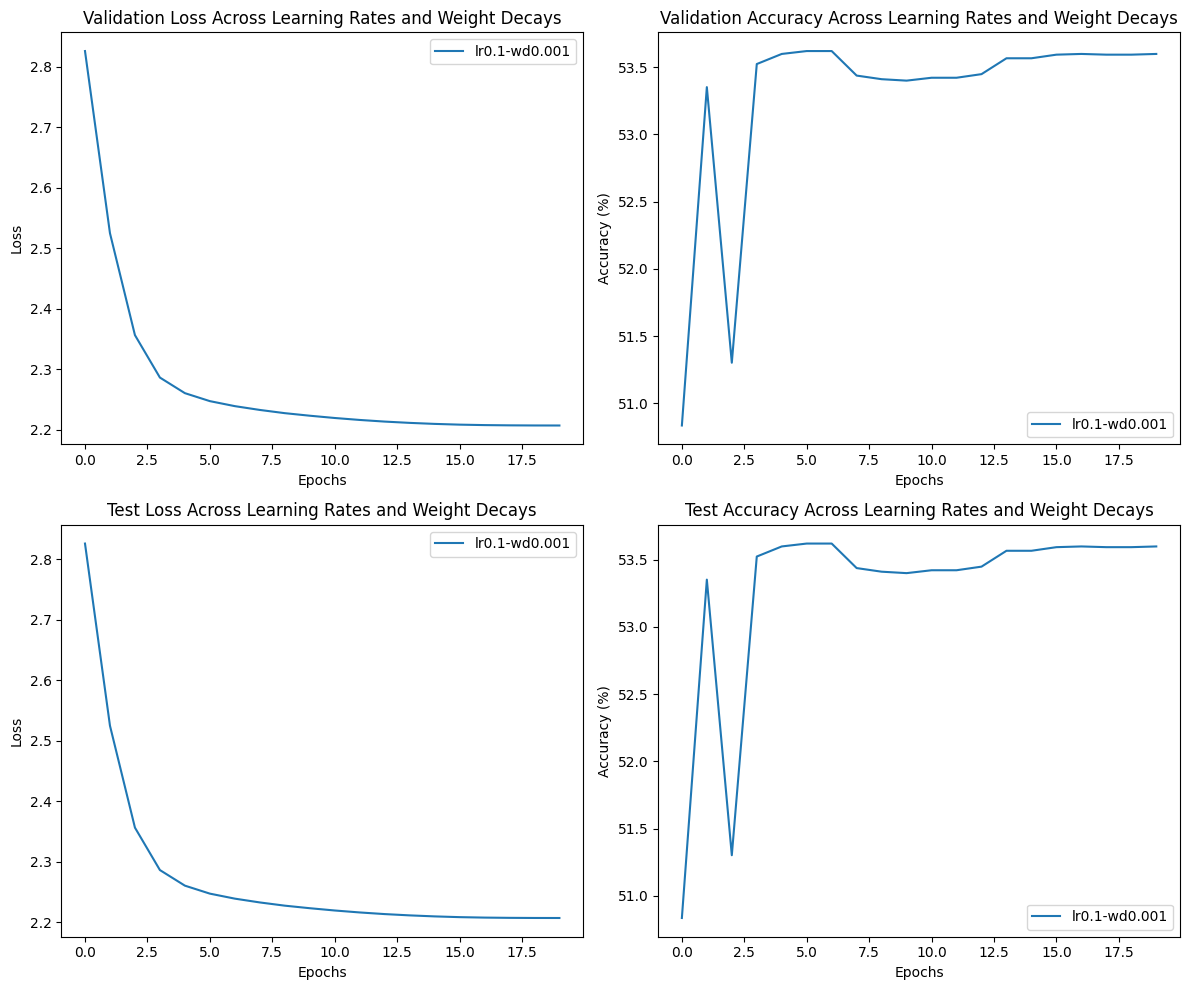

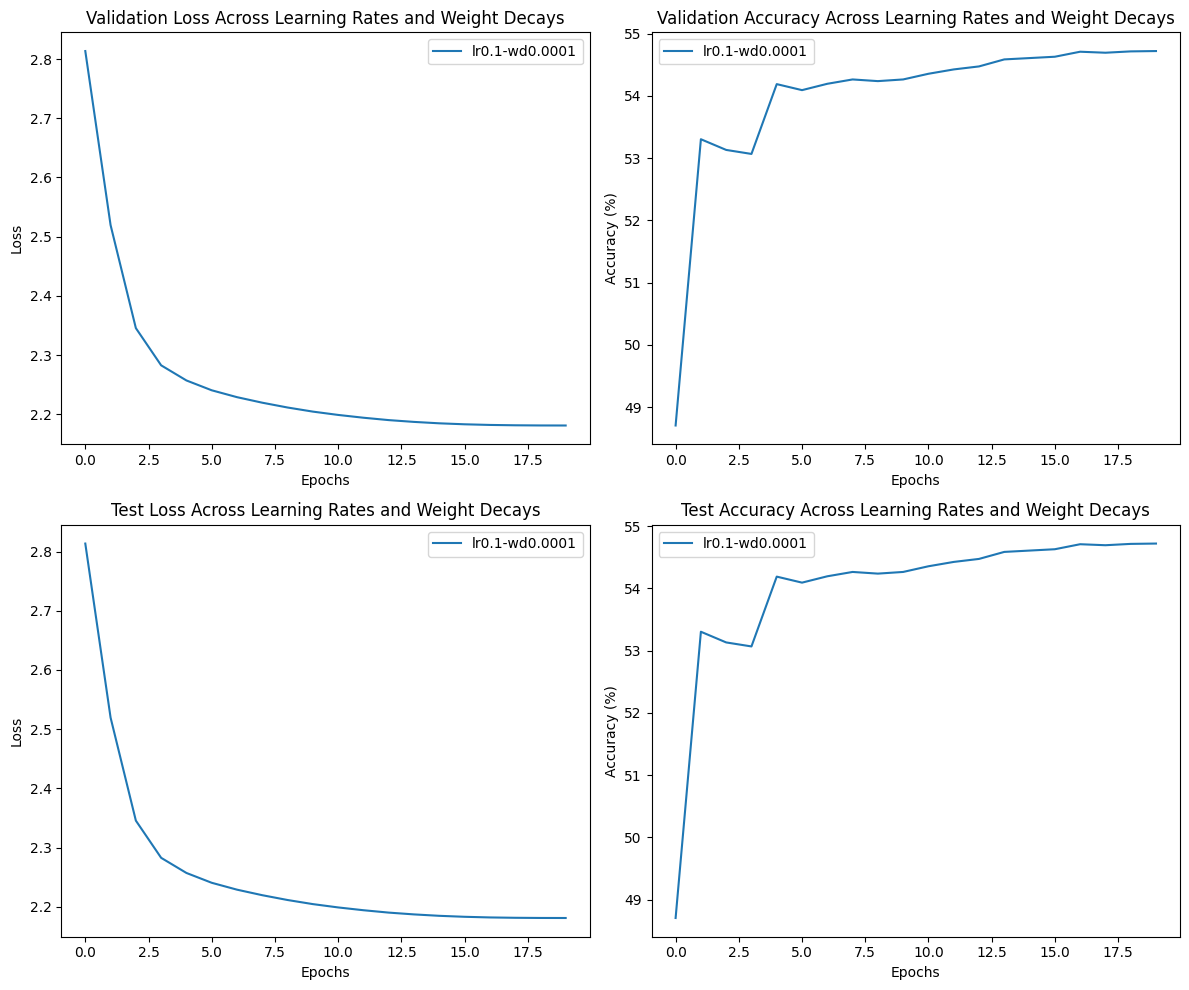

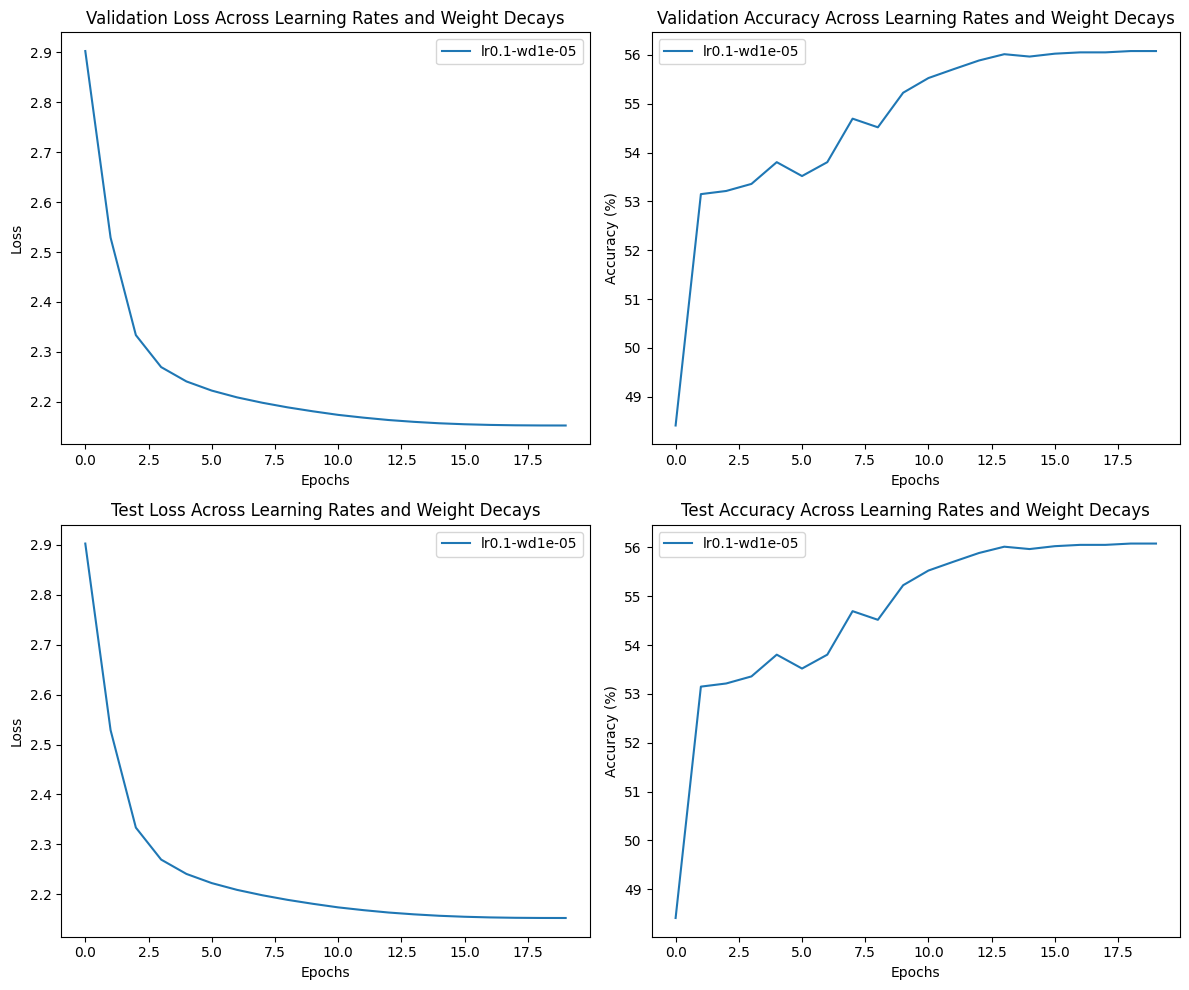

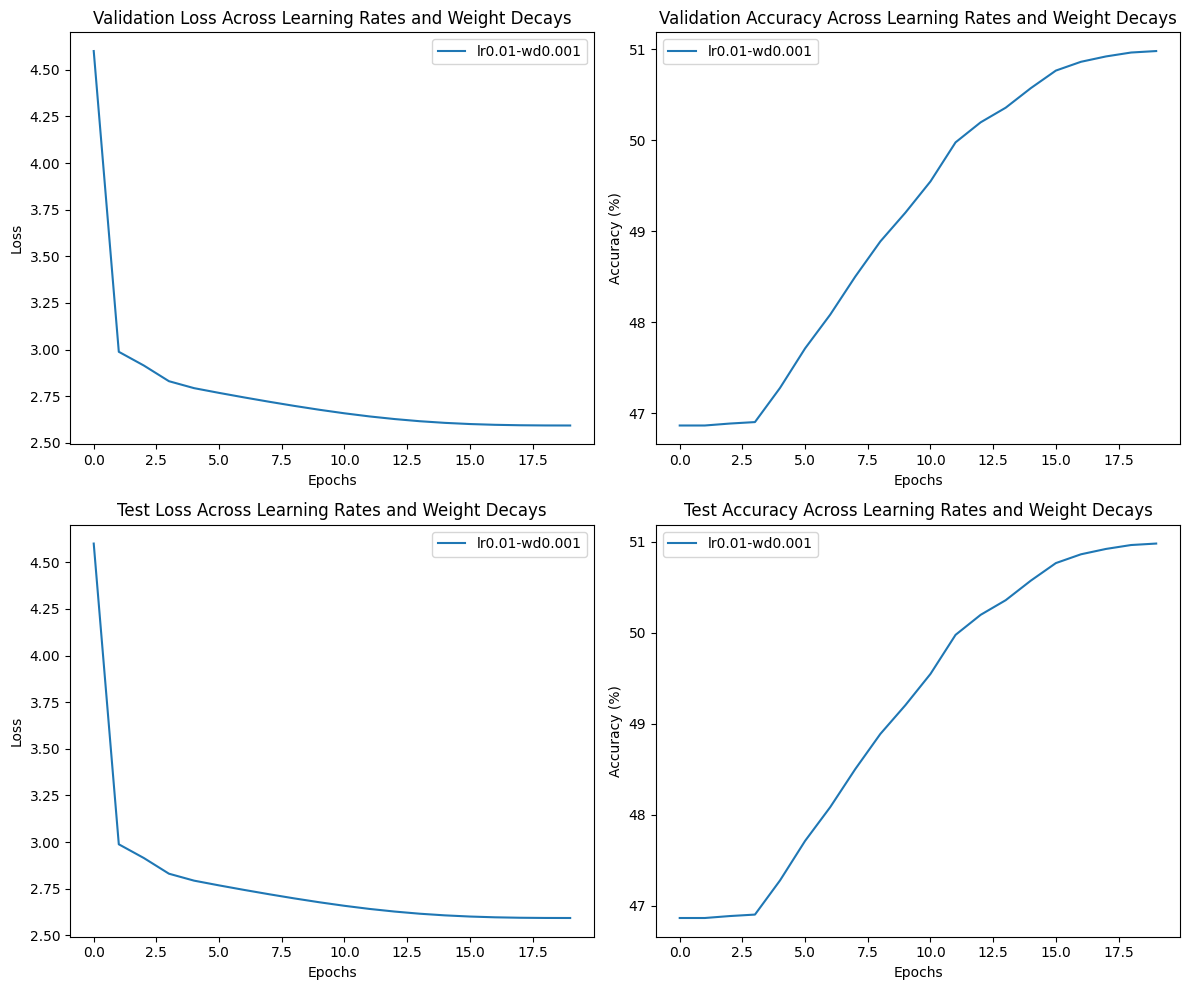

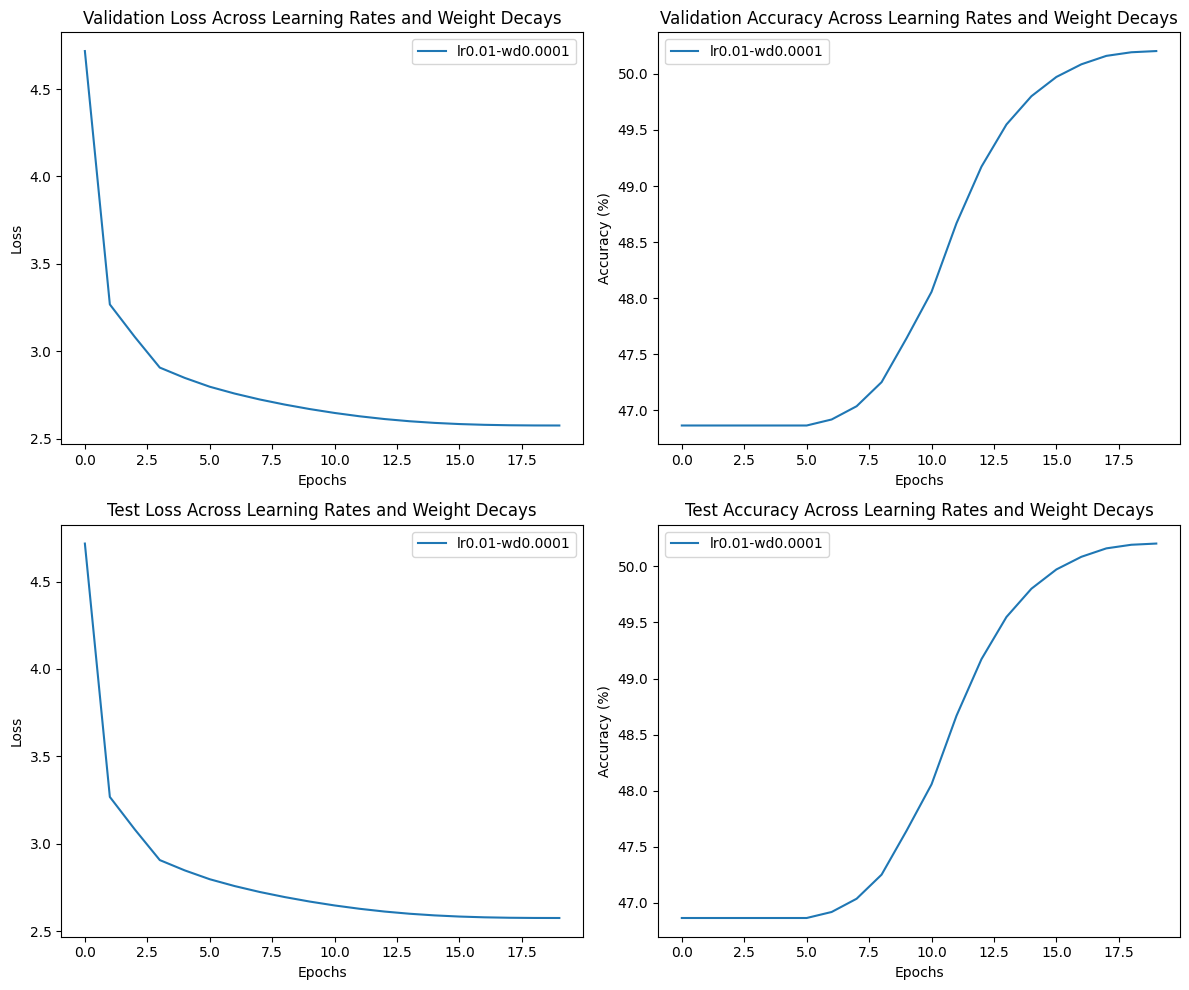

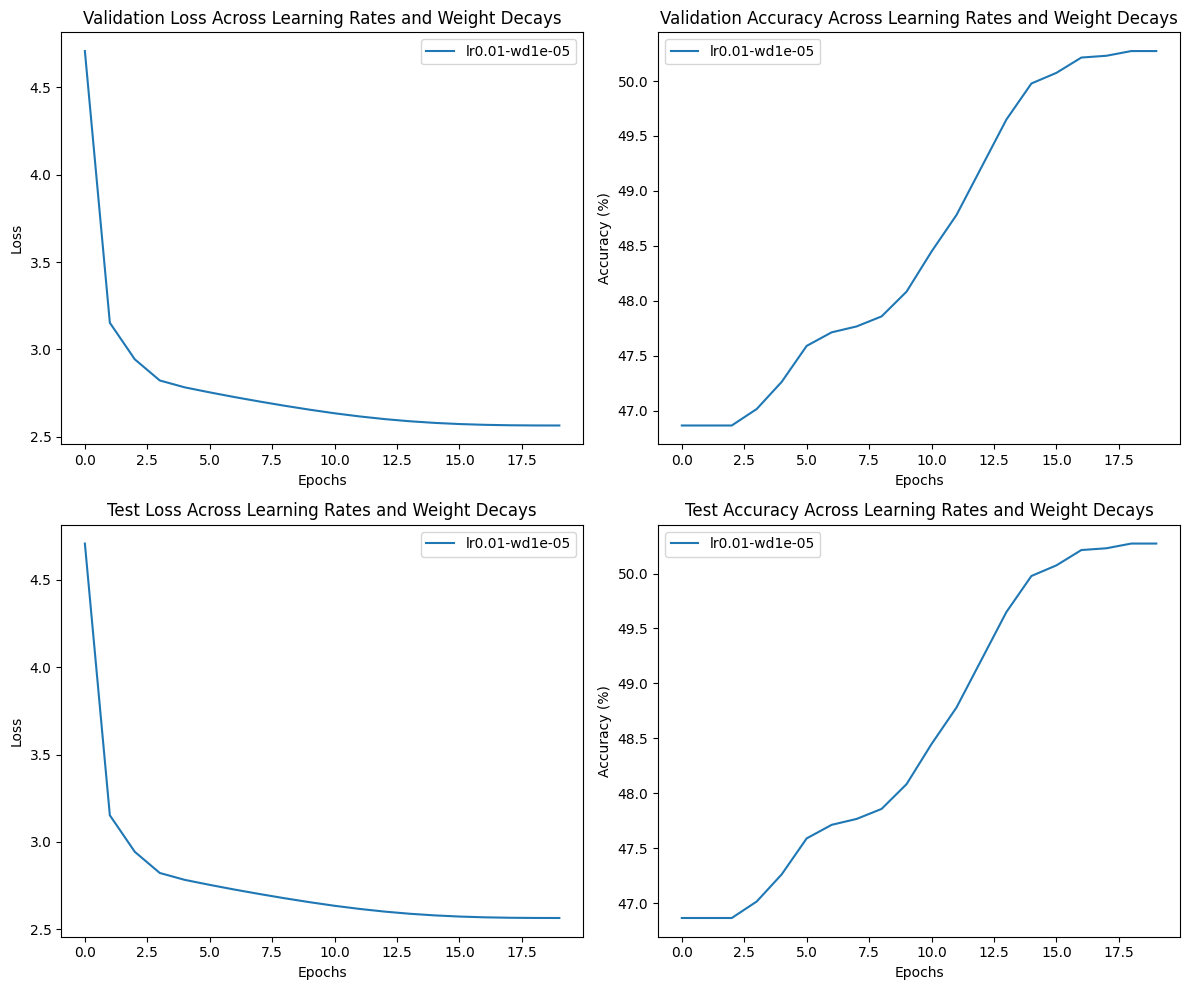

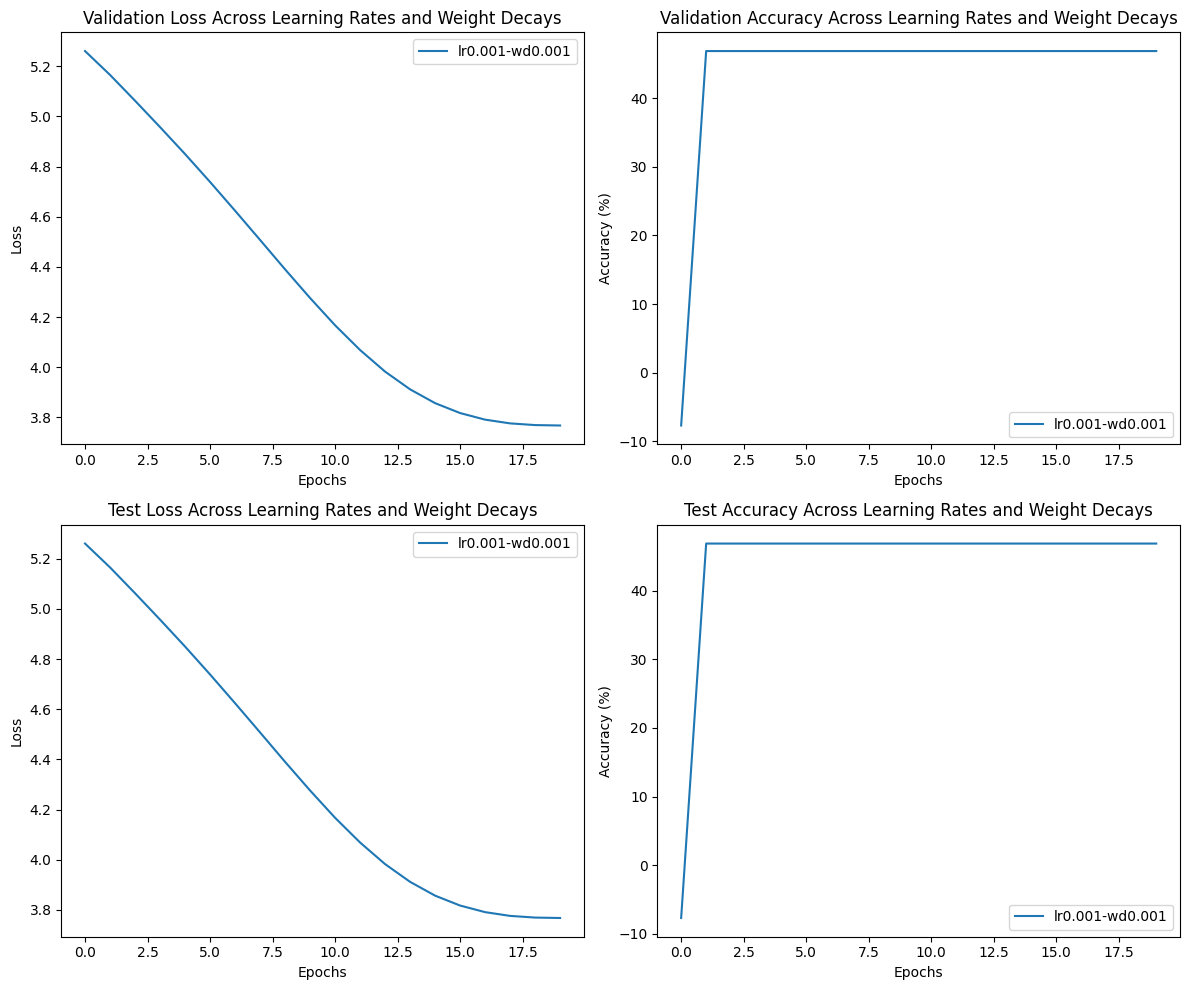

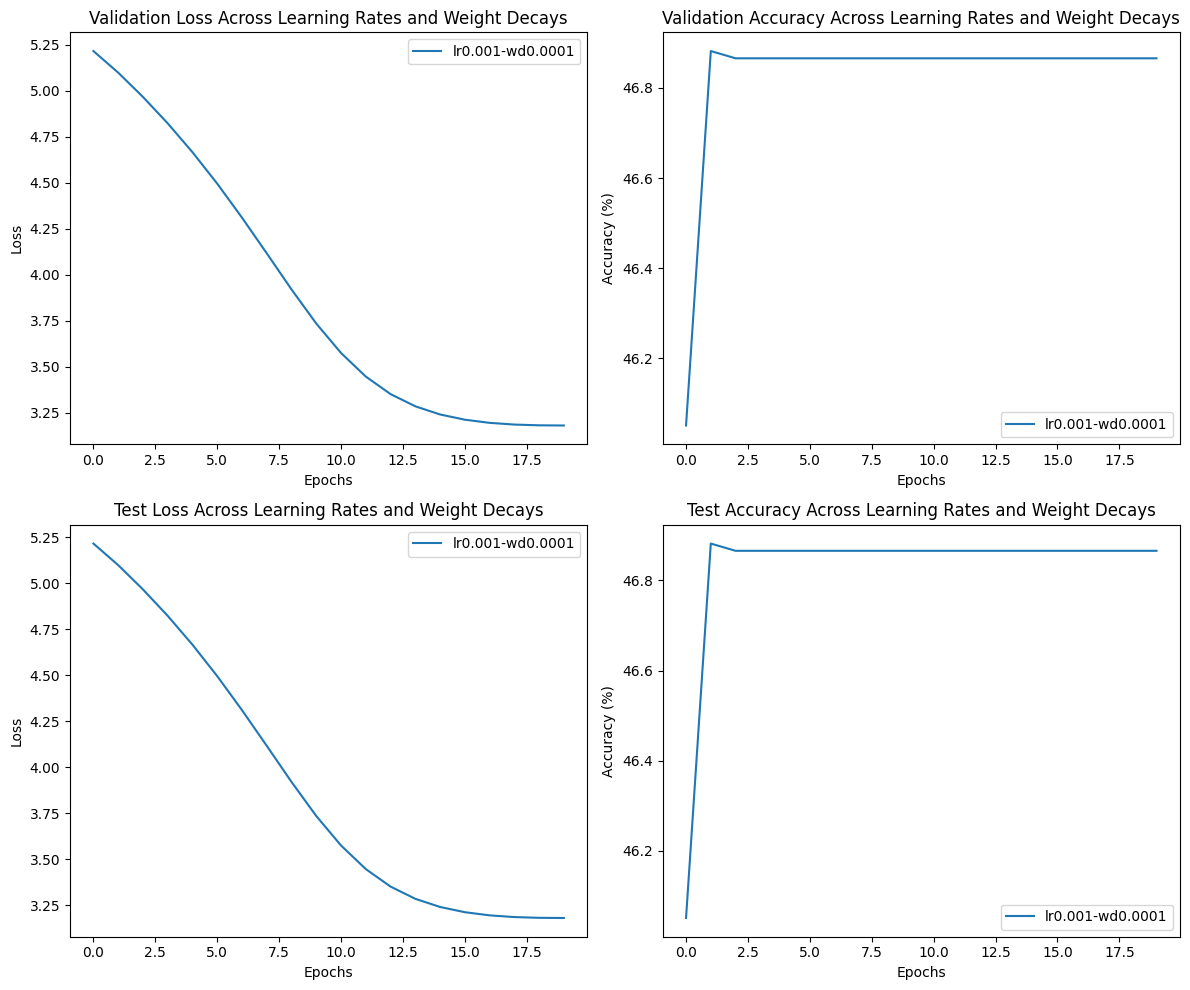

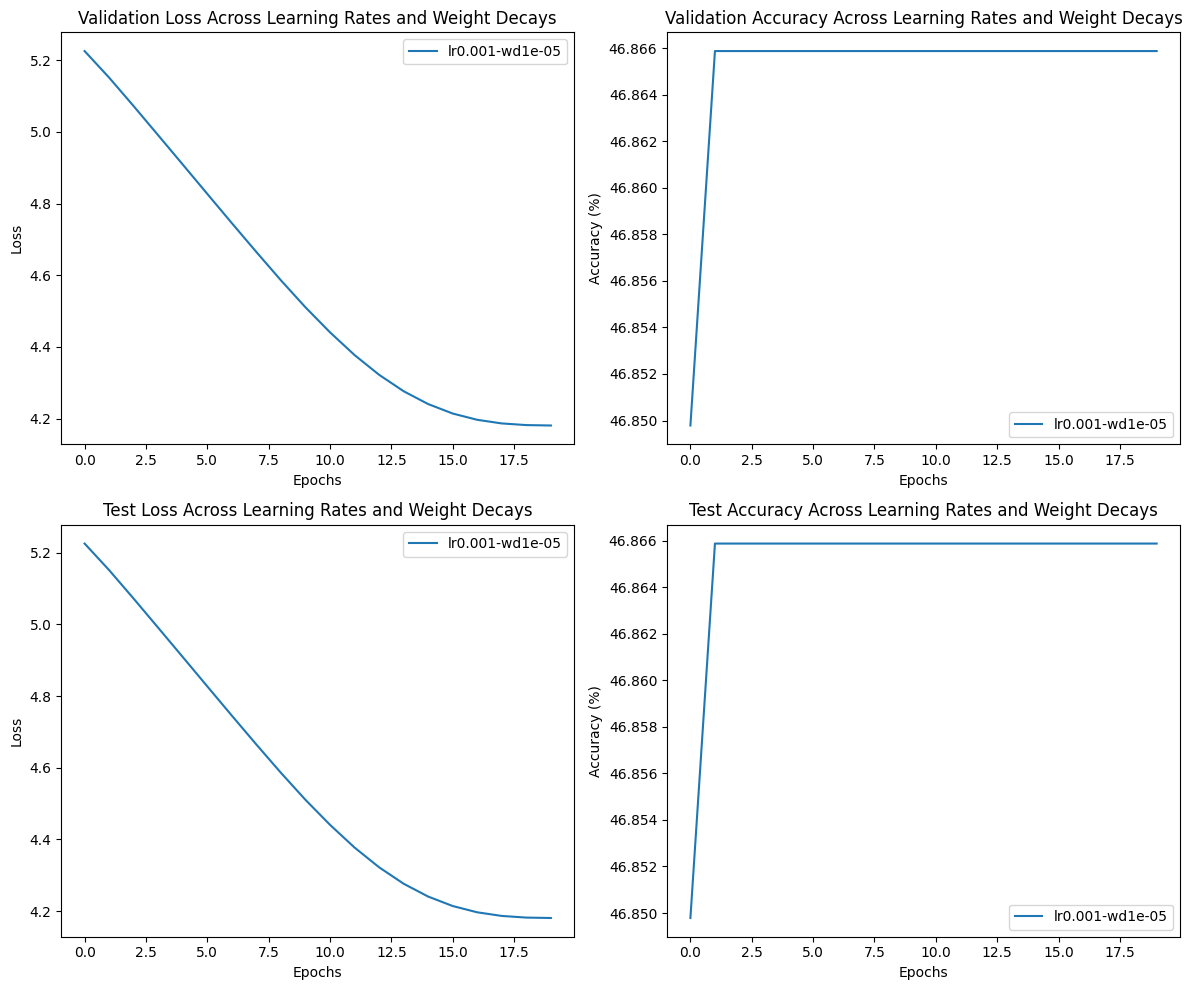

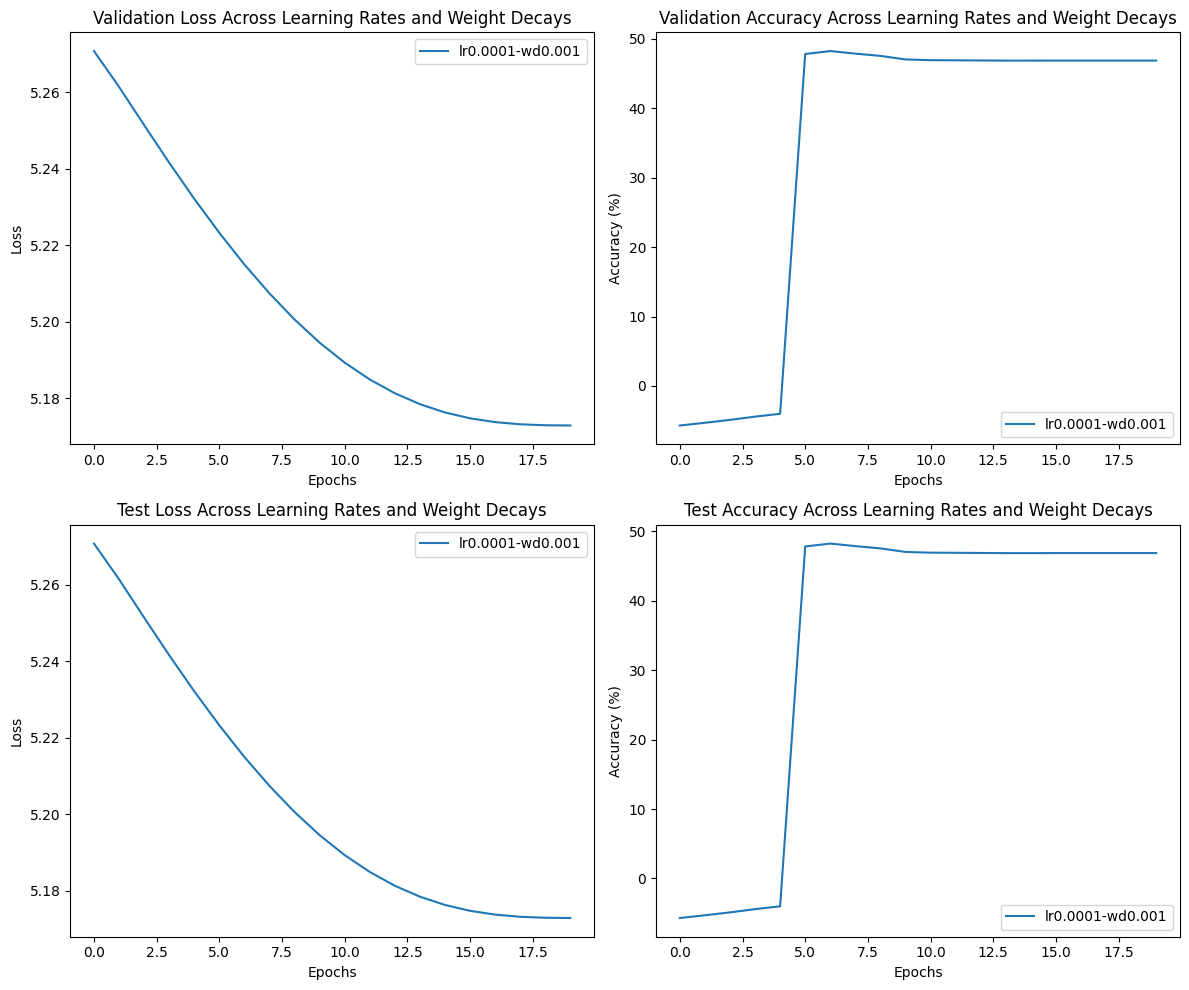

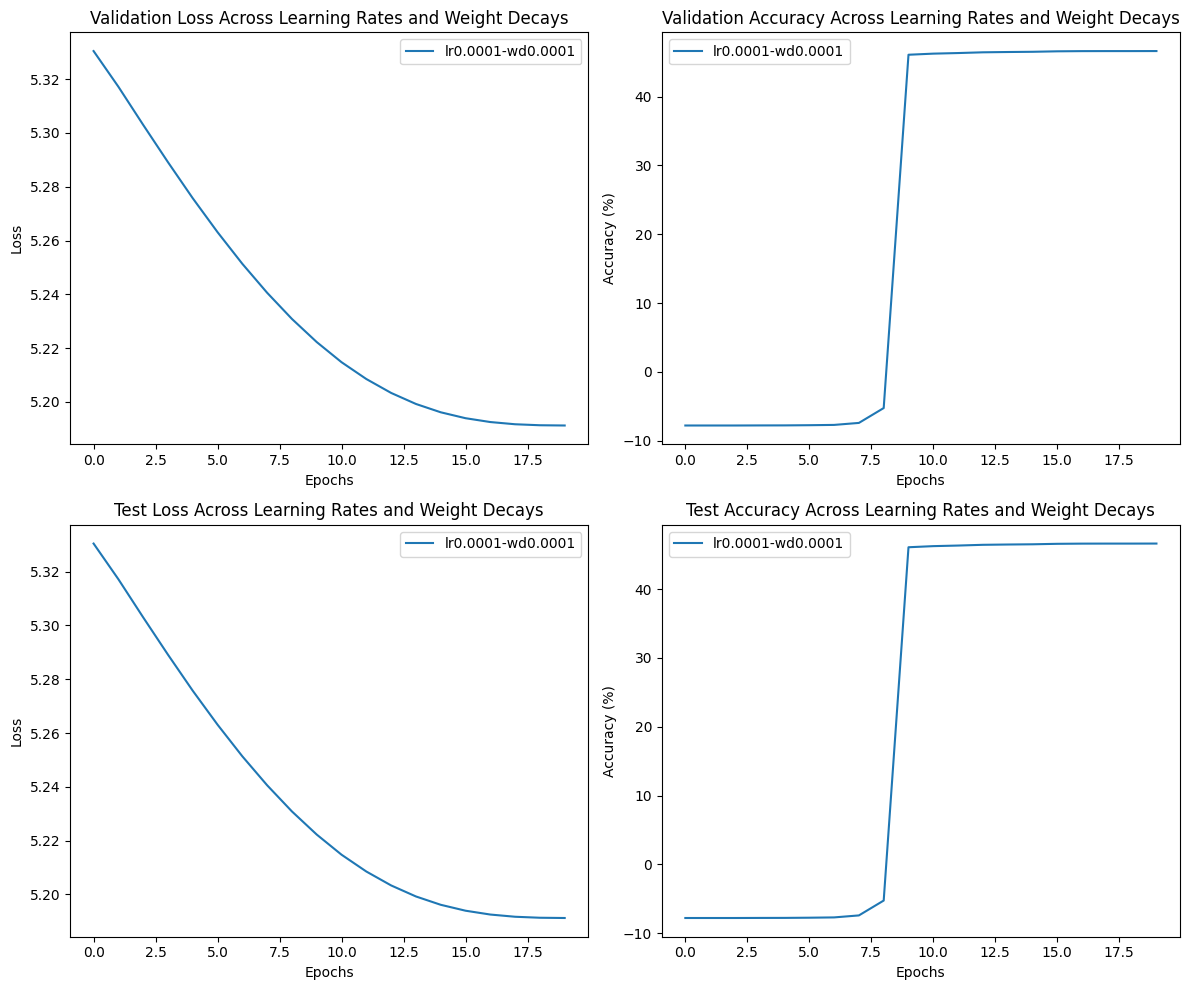

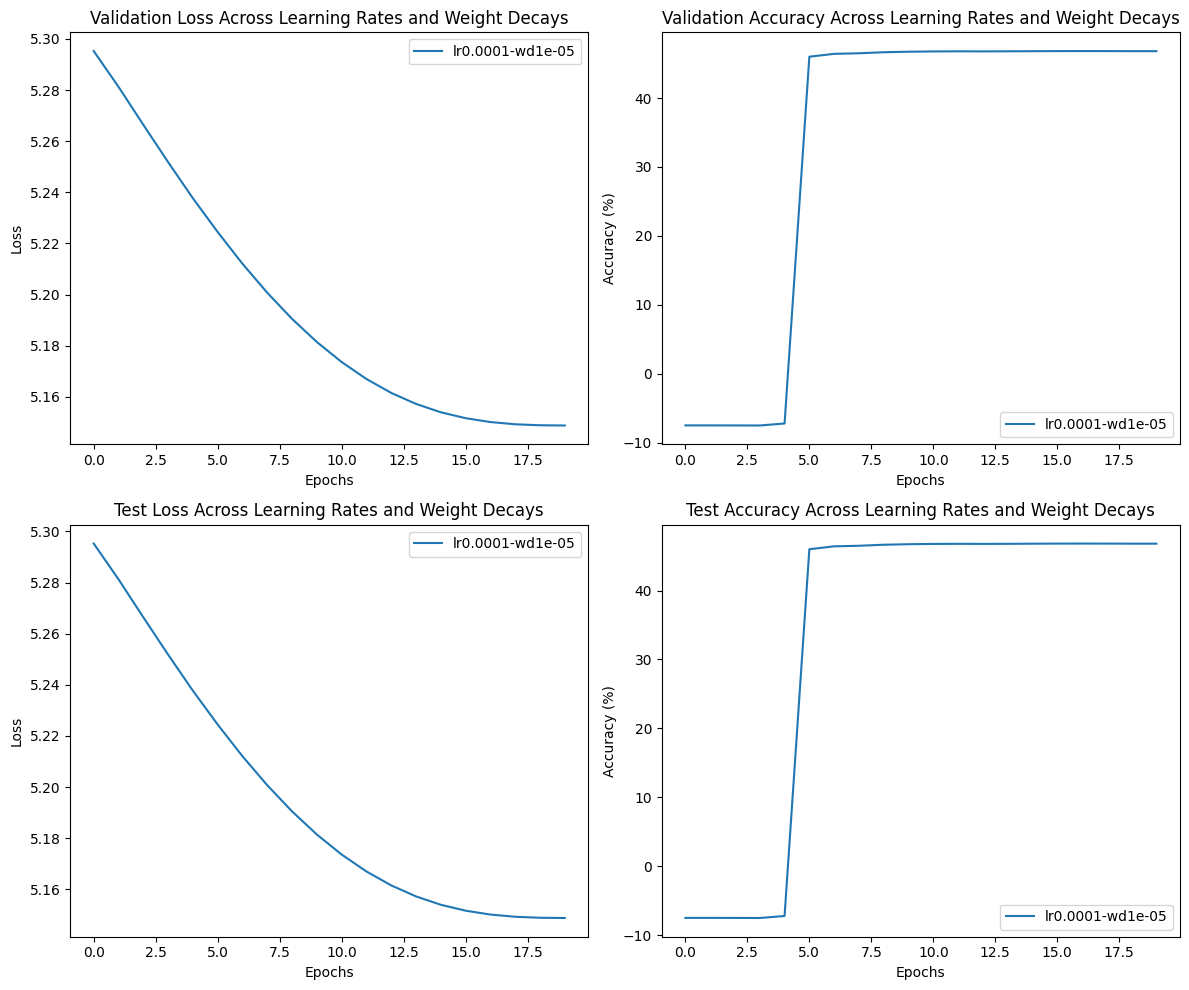

In [20]:
def main():
    # Dataset and training configurations
    data_path = "shakespeare.txt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    epochs = 20  # Number of epochs for centralized training -> # TODO search hyperparameters for different epochs from 20 to 200
    seq_length = 80  # Sequence length for LSTM inputs
    batch_size = 64 # batch size for centralized
    n_vocab = 90 # Character number in vobulary (ASCII)    
    # learning_rate = np.logspace(-3, 1, num=11) # Paper 2 give a range for learning rate's value from 10^(-3) to 10^1
    learning_rate = [1e-1, 1e-2, 1e-3, 1e-4]
    embedding_size = 8
    hidden_dim = 256
    train_split = 0.8 # In LEAF Dataset the common split used is 80/20
    momentum = 0.9 
    weight_decay = [1e-3, 1e-4, 1e-5]

    # Load data
    train_data, test_data = parse_shakespeare(data_path, train_split)

    # Centralized Dataset Preparation
    train_dataset = ShakespeareDataset(train_data, seq_length=seq_length, n_vocab=n_vocab)
    test_dataset = ShakespeareDataset(test_data, seq_length=seq_length, n_vocab=n_vocab)
    train_size = int(0.8 * len(train_dataset))  # 80% of data for training
    val_size = len(train_dataset) - train_size  # 20% of data for validation
    train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ====================
    # Start Centralized Training
    # ====================
    print("Starting centralized training...")

    # Saving best result
    best_result = {
        "hyperparameters": None,
        "val_accuracy": 0.0,
        "val_loss": float('inf'),
        "test_loss": float('inf'),
        "test_accuracy": 0.0
    }
    test_tot_losses = {}
    test_tot_accuracies = {}
    
    for lr in learning_rate:
        for wd in weight_decay:
            print(f"Learning Rate = {lr} and Weight Decay = {wd}")

            model = CharLSTM(n_vocab, embedding_size, hidden_dim, seq_length, num_layers=2)  # Initialize LSTM model
            criterion = nn.CrossEntropyLoss()  # Loss function
            optimizer = optim.SGD(model.parameters(), lr, momentum, 0, wd)  # Optimizer
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # Learning rate scheduler


            # Train and evaluate centralized model
            train_losses, train_accuracies, validation_losses, validation_accuracies, test_losses, test_accuracies = train_centralized(
                model, train_loader, test_loader, val_loader, criterion, optimizer, scheduler, epochs, device, lr, wd
            )
            test_tot_losses[f"Learning Rate = {lr} and Weight Decay = {wd}"] = test_losses
            test_tot_accuracies[f"Learning Rate = {lr} and Weight Decay = {wd}"] = test_accuracies

            if validation_losses[-1] < best_result["val_loss"]:
                best_result["hyperparameters"] = f"LR={lr} WD={wd}"
                best_result["val_accuracy"] = validation_accuracies[-1]
                best_result["val_loss"] = validation_losses[-1]
                best_result["test_loss"] = test_losses[-1]
                best_result["test_accuracy"] = test_accuracies[-1]
                print(f"Update best result -> Val Accuracy: {validation_accuracies[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

            plot_results_centralized(validation_losses, validation_accuracies, lr, wd)
            
    # Print best parameters found
    print(f"Best parameters:\n{best_result} ")

# Best parameters:
# {'hyperparameters': 'LR=0.1 WD=1e-05', 
# 'val_accuracy': 56.077253218884124, 'val_loss': 2.1526712357997893, 
# 'test_loss': 2.3020197378961664, 'test_accuracy': 53.90506872852234}  

if __name__ == "__main__":
    main()
